In [3]:
import pandas as pd
import skopt as sko
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#Library to evaluate performance and optimize ML
#Parallelizing and memory evaluation obtained through this library.  
#https://joblib.readthedocs.io/en/stable/
from joblib import Memory, Parallel, delayed

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer

from collections import OrderedDict   

#Utilizes Bayesian Search Optimizer from ScikitLearn Optimizer Library
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
from skopt import BayesSearchCV

#Get rid of all the annoying BayesSearchCV warnings associated with the RandomForestClassifier
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
#Very simplistic ML model for RandomForestClassifier running ML with 5 Fold Cross Validation
#Pull data
#Import data from white wines
winedata = pd.read_csv("winequality-white.csv",sep=';')
winelabels = None

#Determine which features are most correlated with predicted quality
display(winedata.corr()['quality'].sort_values(ascending=False))

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

In [5]:
#Make a simple function that returns the log transformation of a column within the dataset 
#But not one that performs transformation on the ENTIRE dataset as not all features benefit from this transform.

def log_transform(col):
    return np.log(col[0])

#log transform these values within the dataset

def logtrans(data):
    logtrans = data.copy()
    if 'residual sugar' in logtrans.columns:
        logtrans['residual sugar'] = logtrans[['residual sugar']].apply(log_transform, axis=1)
    if 'chlorides' in logtrans.columns:
        logtrans['chlorides'] = logtrans[['chlorides']].apply(log_transform, axis=1)
    if 'free sulfur dioxide' in logtrans.columns:
        logtrans['free sulfur dioxide'] = logtrans[['free sulfur dioxide']].apply(log_transform, axis=1)
    logtrans['total sulfur dioxide'] = logtrans[['total sulfur dioxide']].apply(log_transform, axis=1)
    logtrans['sulphates'] = logtrans[['sulphates']].apply(log_transform, axis=1)


    return logtrans

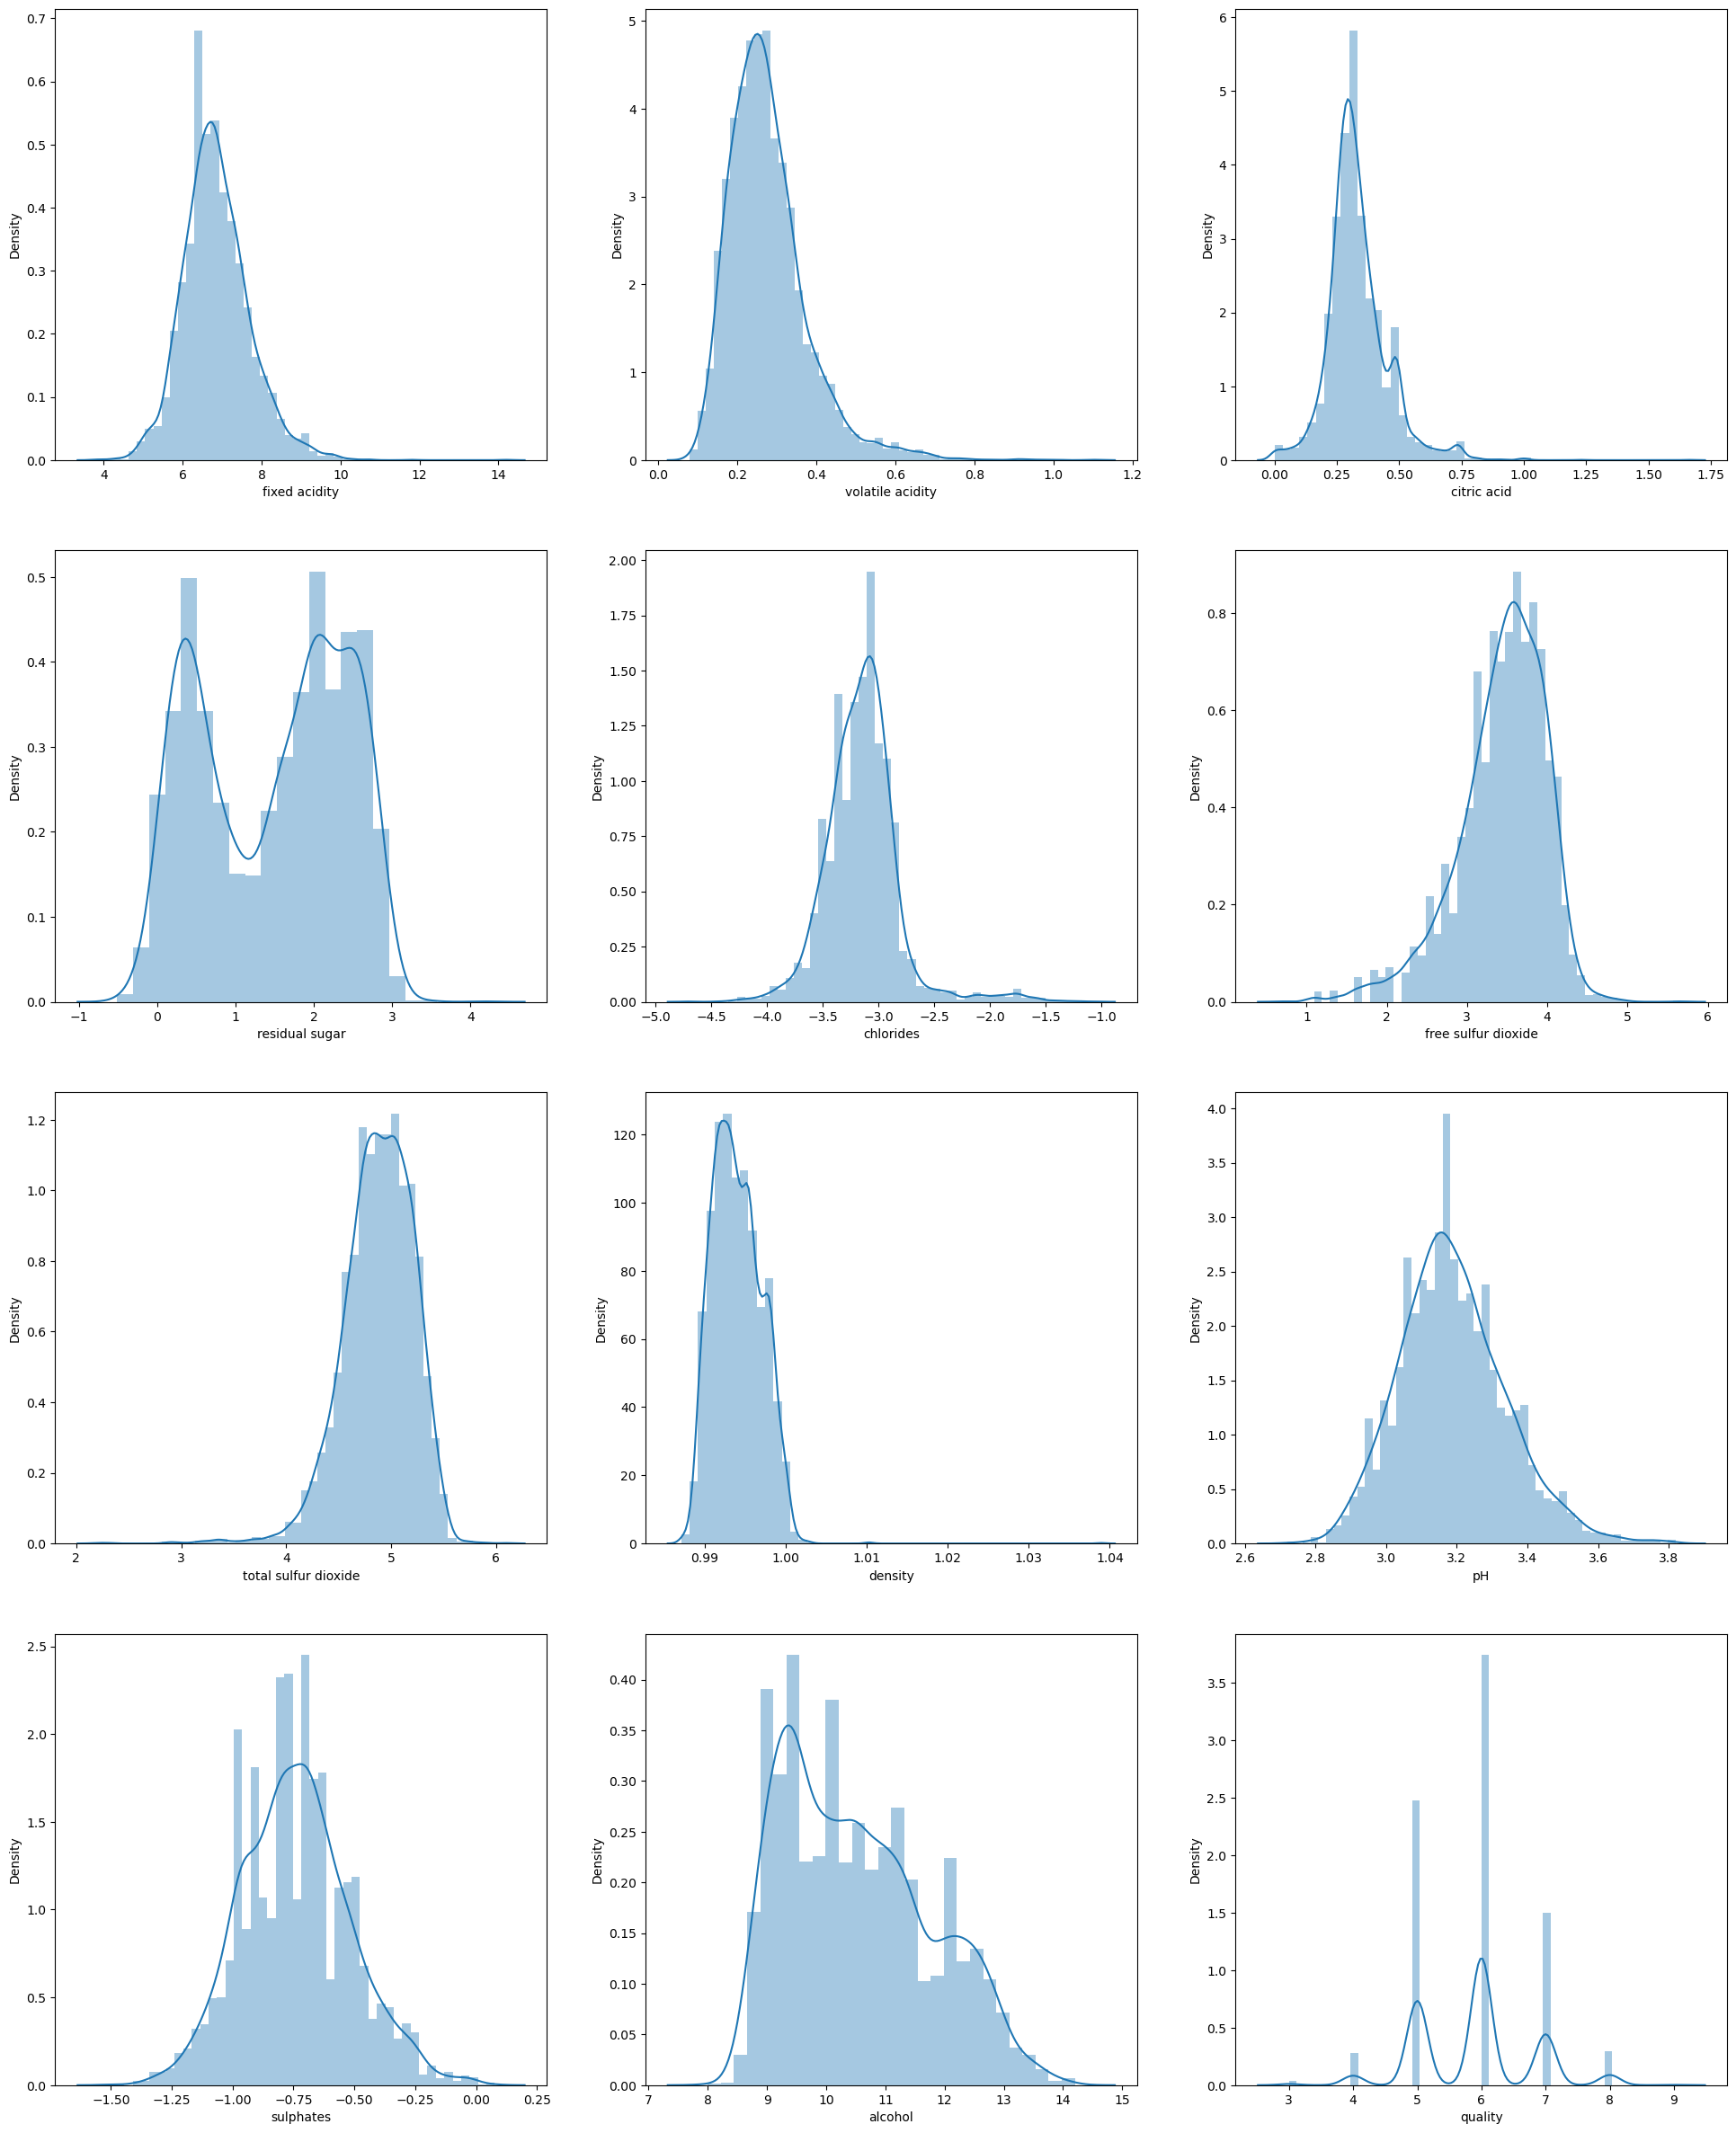

In [6]:
logscale= logtrans(winedata)

color = sb.color_palette("pastel")
warnings.filterwarnings('ignore')

fig, ax1 = plt.subplots(4,3, figsize=(24,30))
k = 0
columns = list(logscale.columns)
for i in range(4):
    for j in range(3):
        try: sb.distplot(logscale[columns[k]], ax = ax1[i][j])
        except: break
        k += 1
plt.show()

if 'quality' in logscale.columns: 
    logscale.pop('quality')

#Transform and scale our data and pull out labels

transwinedata = winedata.copy()

winelabels = transwinedata.pop('quality')

scaled = pd.DataFrame(StandardScaler().fit_transform(transwinedata), columns=transwinedata.columns)

logscaledata = logscale.copy()
logscaledf = pd.DataFrame(StandardScaler().fit_transform(logscaledata), columns=logscaledata.columns)


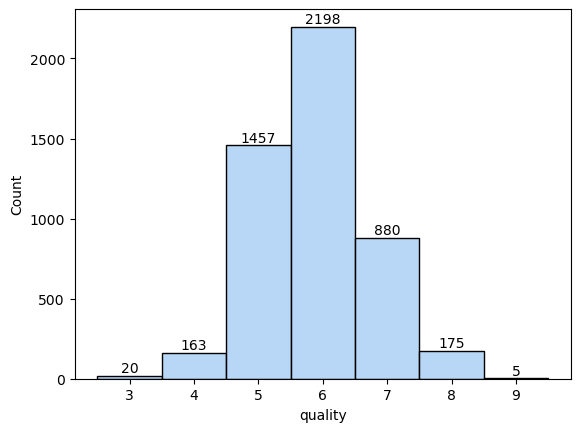

In [7]:
#Show wine class distributions 

#Pull out white wine labels
if 'quality' in winedata.columns: winelabels = winedata.pop('quality')

#Make Histogram
sb.set_palette('pastel')
ax = sb.histplot(winelabels,discrete=True)

# label each bar in histogram
for p in ax.patches:
 height = p.get_height() # get the height of each bar
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), # x-coord position of txt, padded to mid
 y = height+20, # y-coord position of txt, padded 20 above bar
 s = '{:.0f}'.format(height), # text
 ha = 'center') # set horizontal align to center
plt.show()


In [8]:
try: performance_scores = pd.read_excel('performance_scores.xlsx', index=False, header=None)
except: performance_scores = pd.DataFrame(columns=['Search_Type', 'Training_Accuracy', 'Test_Accuracy', 
                                          'Fit_Time', 'Best_Search_Accuracy_Score', 'Opt_Method', 'Best_Parameters'],index=None)


display(performance_scores)
performance_scores.columns


Empty DataFrame
Columns: [Search_Type, Training_Accuracy, Test_Accuracy, Fit_Time, Best_Search_Accuracy_Score, Opt_Method, Best_Parameters]
Index: []

Index(['Search_Type', 'Training_Accuracy', 'Test_Accuracy', 'Fit_Time',
       'Best_Search_Accuracy_Score', 'Opt_Method', 'Best_Parameters'],
      dtype='object')

In [9]:
#Split white datasets before anything to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(logscaledf, winelabels, random_state=24)

In [10]:
#get CV scores from dataset split into 10, get scores for before scaling (prescaled performance)
rfc = RandomForestClassifier()

knn = KNeighborsClassifier()

scores = cross_val_score(rfc, winedata, winelabels, cv=5)
print(scores)

knnscores = cross_val_score(knn, winedata, winelabels, cv=5)
print(knnscores)


[0.50204082 0.49693878 0.53877551 0.50766088 0.53524004]
[0.38061224 0.38877551 0.40816327 0.39632278 0.40960163]


In [11]:
#run same with ShuffleSplit
n_samples = logscaledf.shape[0]
cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
scores2 = cross_val_score(rfc, logscaledf, winelabels, cv=cv)
knnscores2 = cross_val_score(knn, logscaledf, winelabels, cv=cv)

In [12]:
#Should note improved scores with scaling
print(scores2)
print(knnscores2)

[0.68979592 0.68265306 0.68061224 0.69050051 0.6578141 ]
[0.55918367 0.54489796 0.55102041 0.55975485 0.52706844]


In [13]:
#Define dict random forest hyperparameters from which to optimize/search
rfcparams = {
    'n_estimators': [300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [1, 2],
    'min_weight_fraction_leaf': [0.0],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample'],
    'n_jobs': [-1]
}

In [14]:
#Define knn hyperparameters dict from which to optimize/search
knnparams = {
    'n_neighbors': [2, 5, 10, 25, 50], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'auto'],
    'leaf_size': [5, 10, 15, 20, 30, 40, 50],
    'n_jobs': [-1]
}

In [15]:
#Define a list dataset features most important to model training
#Maybe we can do this in a future exercise.


In [16]:
def report_perf(optimizer, tr_X, tr_y, te_X, te_y, title, subset):
    
    myfit = optimizer.fit(tr_X, tr_y)
    train_pred = optimizer.predict(tr_X)
    test_pred = optimizer.predict(te_X)
    train_acc = accuracy_score(train_pred, tr_y)
    test_acc = accuracy_score(test_pred, te_y)
    y_score = myfit.predict_proba(te_X)


    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print(title, "best score post refit:", optimizer.best_score_)
    print("best params: %s" % str(optimizer.best_params_))


    mean_fit_time = optimizer.cv_results_['mean_fit_time']
    mean_score_time = optimizer.cv_results_['mean_score_time']
    n_splits = optimizer.n_splits_ #Num splits of train data
    n_iter = pd.DataFrame(optimizer.cv_results_).shape[0] #Iterations per split
    time = np.mean(mean_fit_time+mean_score_time) * n_splits * n_iter
    
    print("Total Mean Time for ML (in seconds): ", np.mean(mean_fit_time+mean_score_time) * n_splits * n_iter)
    #print(test_pred)
    
    winematrix = confusion_matrix(te_y, test_pred)
    #Get possible labels from the actual test labels and predicted test labels
    labels = np.unique(np.concatenate((te_y, test_pred),0))
    
    if (type(optimizer.best_params_) == 'OrderedDict'):
        bestparams = optimizer.best_params_.items()
    else:
        bestparams = optimizer.best_params_
    
    performance_scores.loc[len(performance_scores)] = [title, train_acc, test_acc, time, 
                                                       optimizer.best_score_, subset,
                                                    str(bestparams)]

    disp = showMatrix(winematrix, display_labels=labels) 
              
    disp.plot()
    plt.grid(False)
    plt.show()
    
    label_binarizer = LabelBinarizer().fit(tr_y)

    y_onehot_test = label_binarizer.transform(te_y)
    y_onehot_test.shape  # (num_samples, num_classes)
    
    for class_of_interest in range(3, max(te_y)+1):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        ax = plt.gca()
        try:
            roc = roc_auc_score(y_onehot_test[:, class_id], y_score[:, class_id], 
                                labels=labels, multi_class='ovr')
            print("Roc_Auc_Score for wine quality", class_of_interest, "is:", roc)

            rfc_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id], y_score[:, class_id],
                                                        name=f"{class_of_interest} vs the rest",
                                                        plot_chance_level=True) 
            rfc_disp.plot(ax=ax, alpha=0.8)
        except:
            print('Oh well, I cant do this for whatever reason')

    return test_acc

Train Accuracy: 0.9983664579362919
Test Accuracy: 0.6840816326530612
RandomizedSearchCV best score post refit: 0.666482047860016
best params: {'n_jobs': -1, 'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
Total Mean Time for ML (in seconds):  133.12428498268127


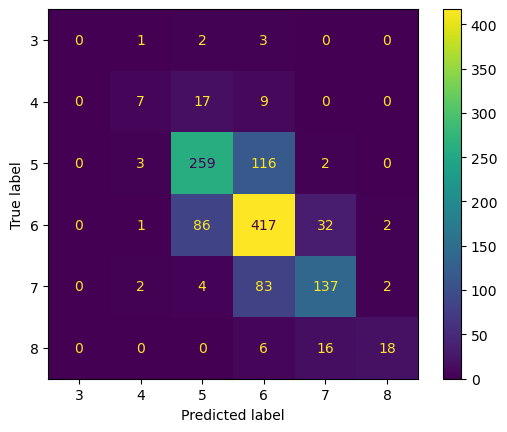

Roc_Auc_Score for wine quality 3 is: 0.8295734208367516
Roc_Auc_Score for wine quality 4 is: 0.8722925564368518
Roc_Auc_Score for wine quality 5 is: 0.8805387729679227
Roc_Auc_Score for wine quality 6 is: 0.829402120095453
Roc_Auc_Score for wine quality 7 is: 0.9154436995196115
Roc_Auc_Score for wine quality 8 is: 0.940886075949367
Train Accuracy: 0.999455485978764
Test Accuracy: 0.6955102040816327
RandomizedSearchCV best score post refit: 0.6667541567035533
best params: {'n_jobs': -1, 'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Total Mean Time for ML (in seconds):  170.42958688735962


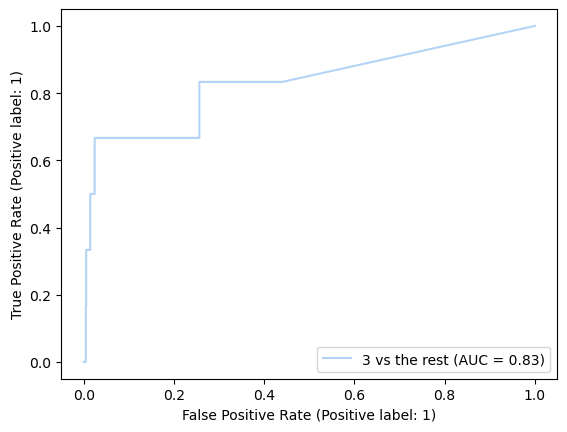

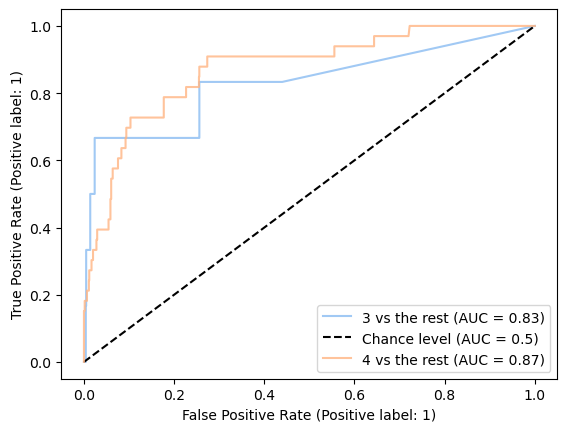

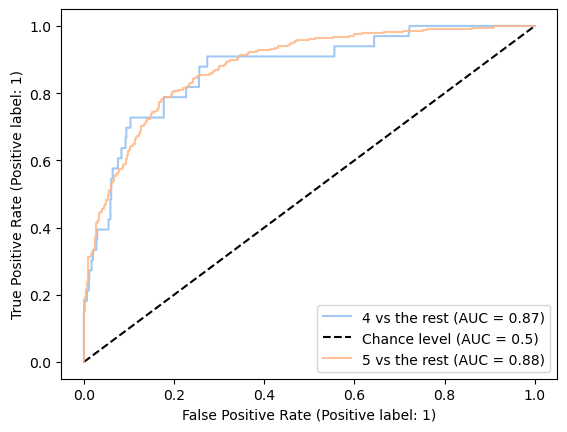

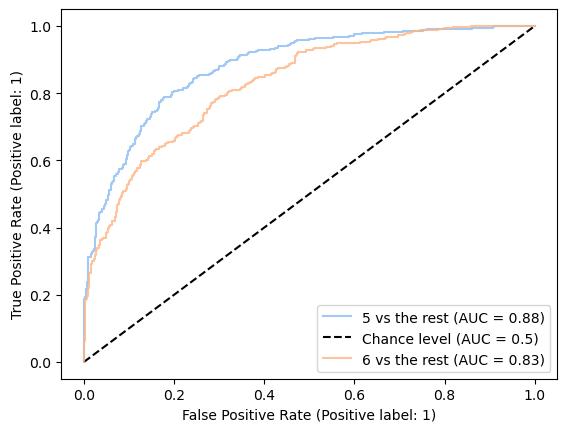

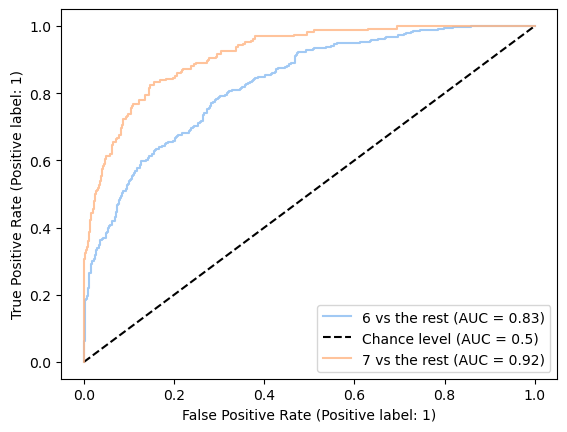

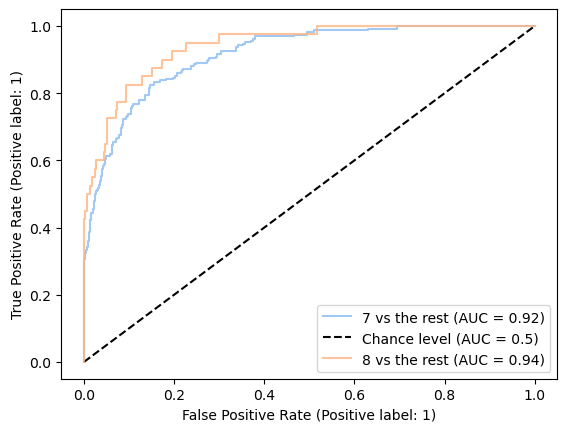

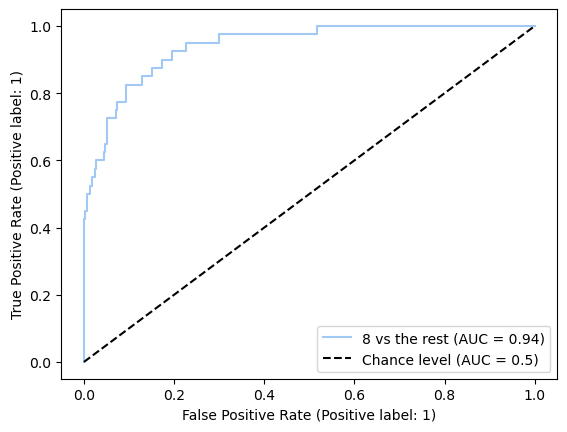

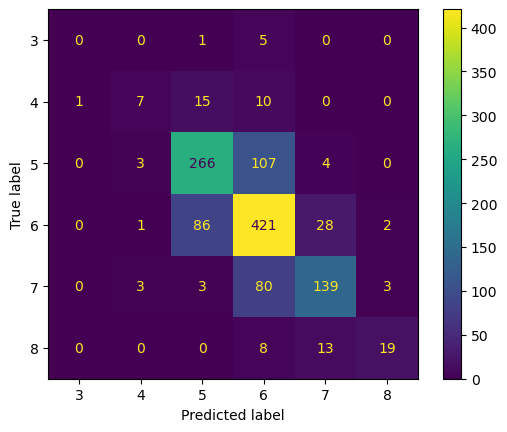

Roc_Auc_Score for wine quality 3 is: 0.8484413453650533
Roc_Auc_Score for wine quality 4 is: 0.8618314012609314
Roc_Auc_Score for wine quality 5 is: 0.8849081283089381
Roc_Auc_Score for wine quality 6 is: 0.828996282527881
Roc_Auc_Score for wine quality 7 is: 0.918008411198508
Roc_Auc_Score for wine quality 8 is: 0.9374472573839663
Train Accuracy: 0.9991832289681459
Test Accuracy: 0.6889795918367347
RandomizedSearchCV best score post refit: 0.6645746909117871
best params: {'n_jobs': -1, 'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Total Mean Time for ML (in seconds):  141.44399857521057


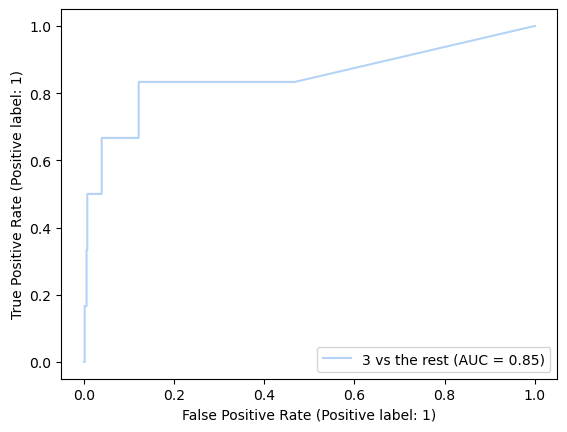

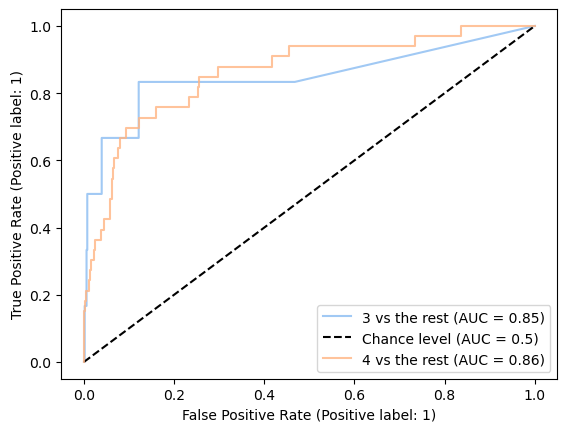

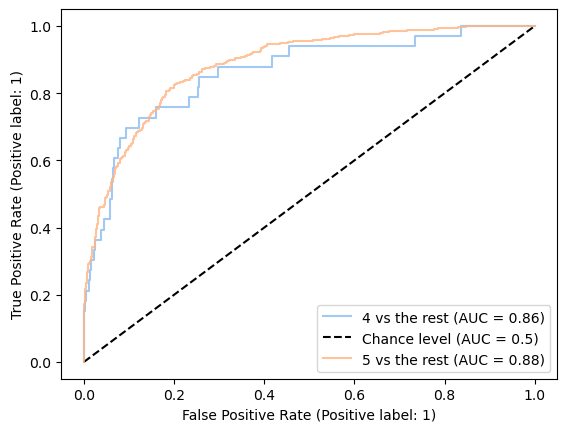

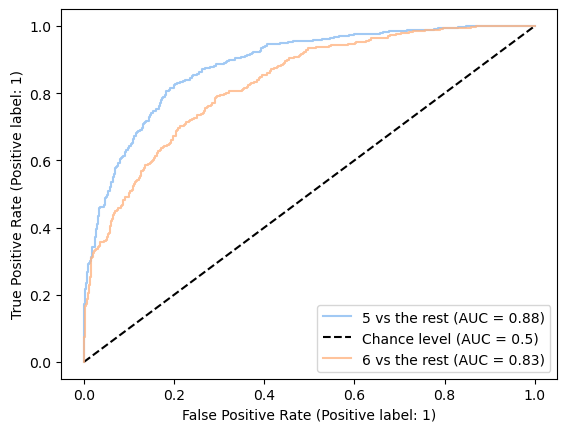

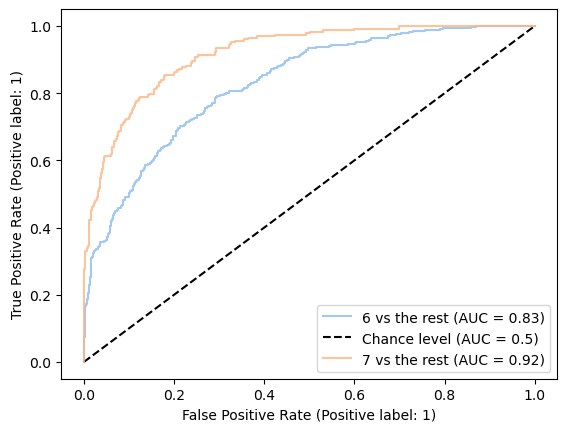

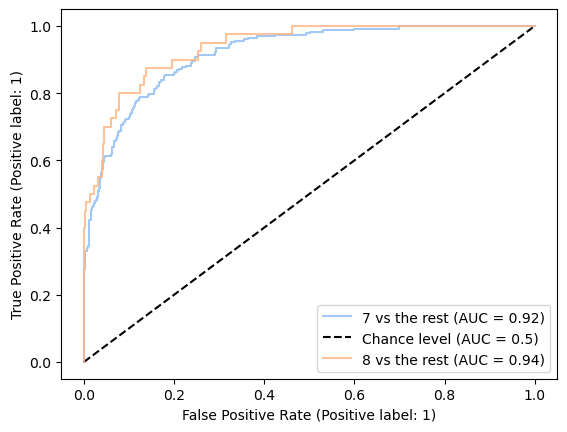

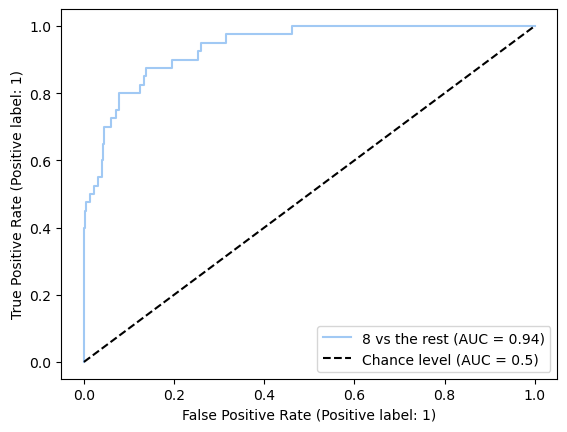

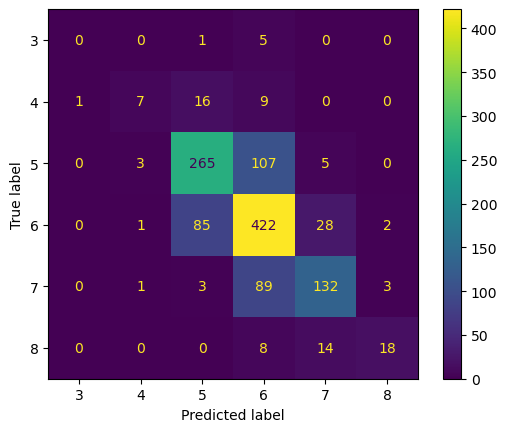

Roc_Auc_Score for wine quality 3 is: 0.8793409898824173
Roc_Auc_Score for wine quality 4 is: 0.8690512507626602
Roc_Auc_Score for wine quality 5 is: 0.8830239800685145
Roc_Auc_Score for wine quality 6 is: 0.8289881657765296
Roc_Auc_Score for wine quality 7 is: 0.9133936898414542
Roc_Auc_Score for wine quality 8 is: 0.9420042194092827
Train Accuracy: 0.9989109719575279
Test Accuracy: 0.6840816326530612
RandomizedSearchCV best score post refit: 0.6681158130827263
best params: {'n_jobs': -1, 'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Total Mean Time for ML (in seconds):  137.3930060863495


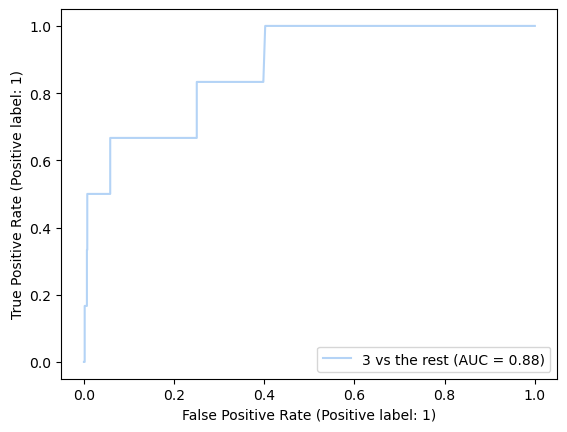

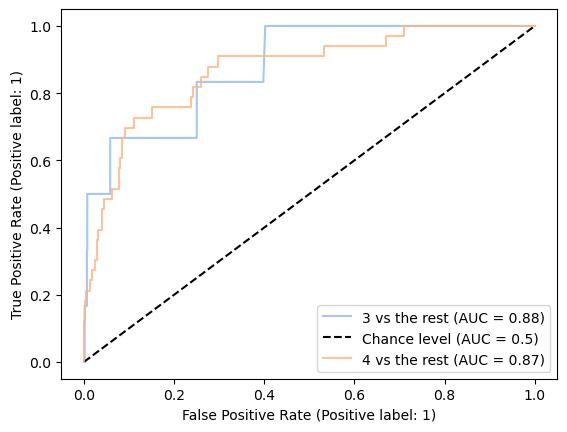

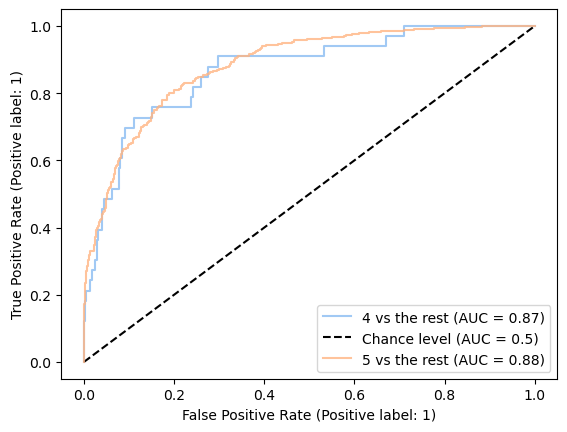

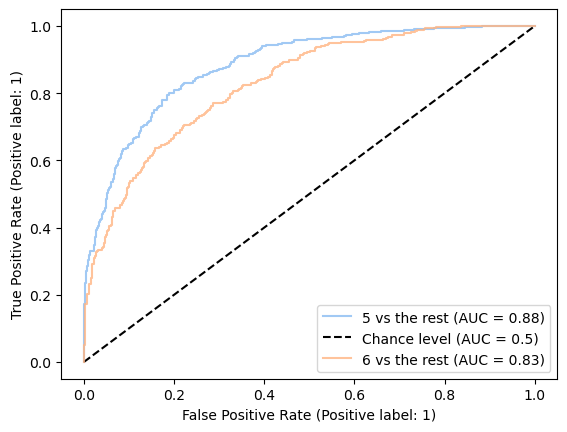

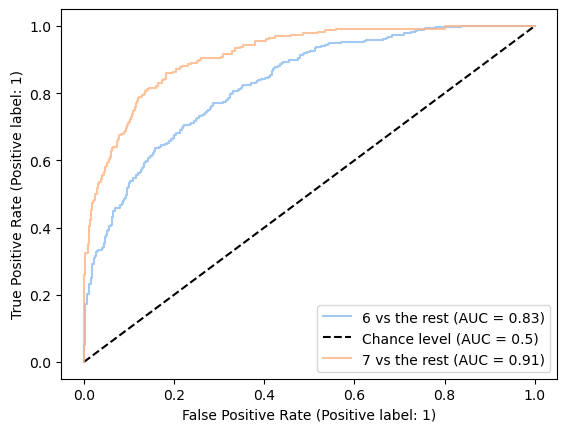

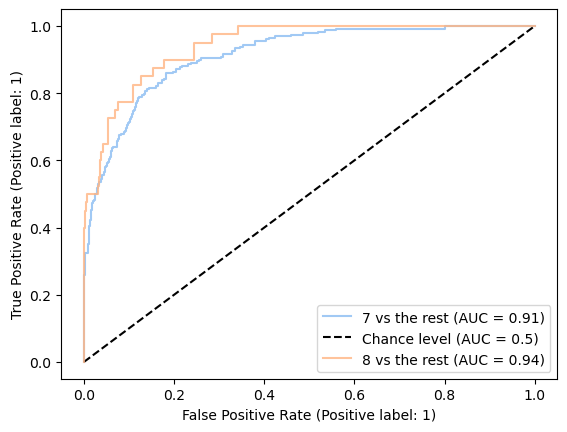

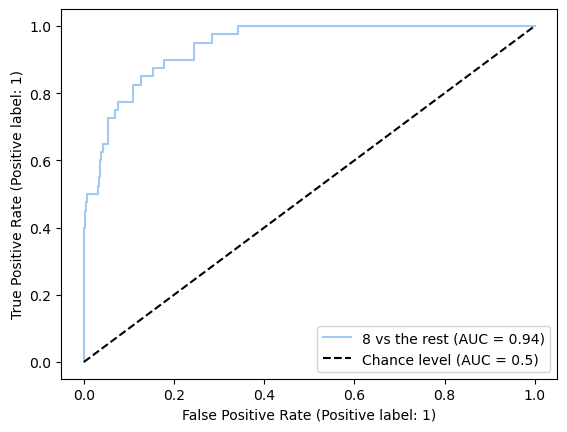

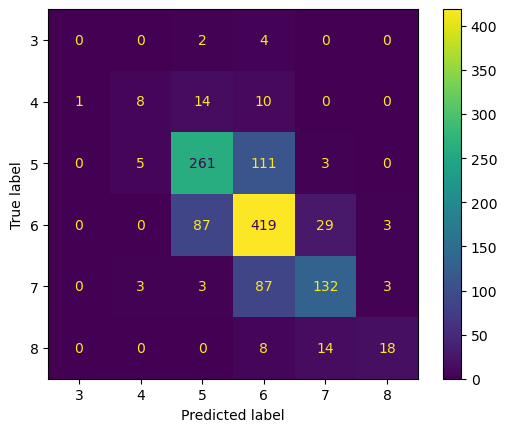

Roc_Auc_Score for wine quality 3 is: 0.8024336888159695
Roc_Auc_Score for wine quality 4 is: 0.8722290014236322
Roc_Auc_Score for wine quality 5 is: 0.8831547804422297
Roc_Auc_Score for wine quality 6 is: 0.8311093434630391
Roc_Auc_Score for wine quality 7 is: 0.915650460152387
Roc_Auc_Score for wine quality 8 is: 0.9386286919831224
Train Accuracy: 0.9978219439150559
Test Accuracy: 0.686530612244898
RandomizedSearchCV best score post refit: 0.6659370887319505
best params: {'n_jobs': -1, 'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
Total Mean Time for ML (in seconds):  118.60619831085205


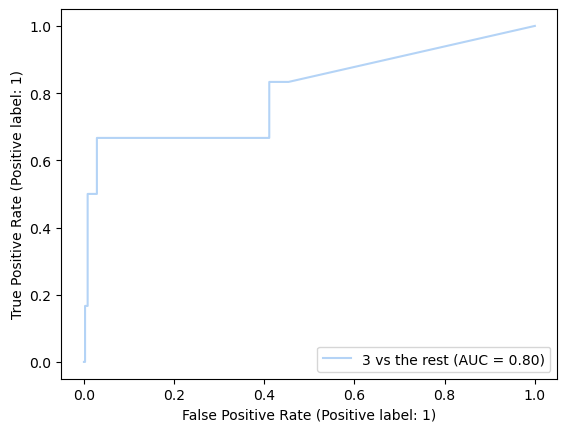

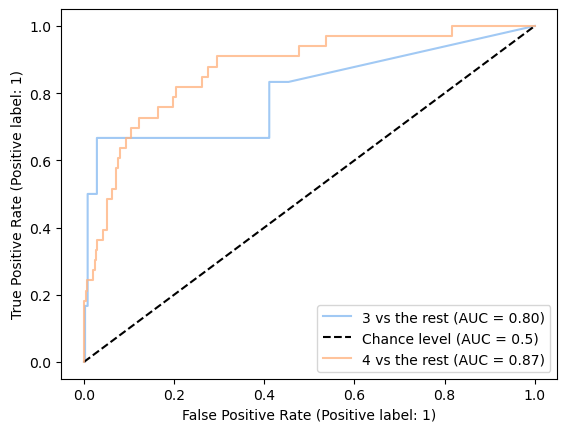

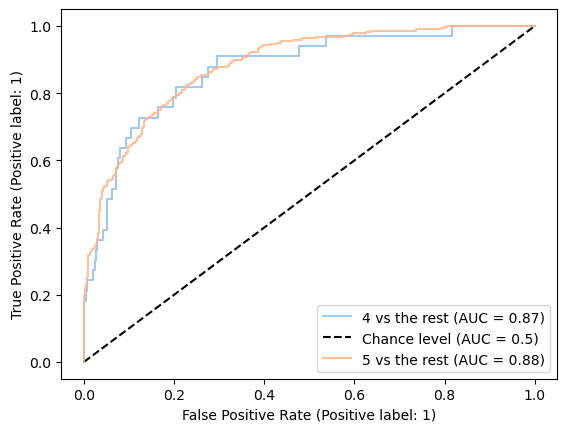

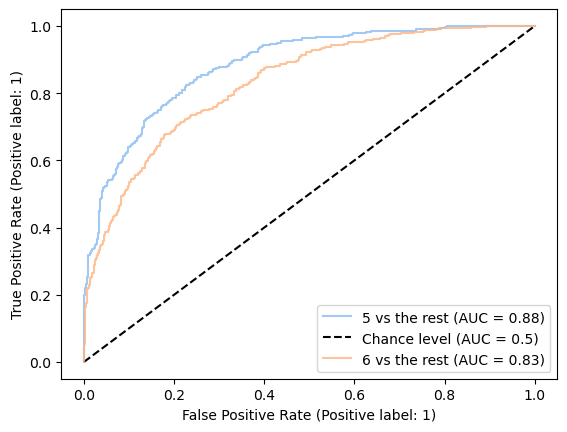

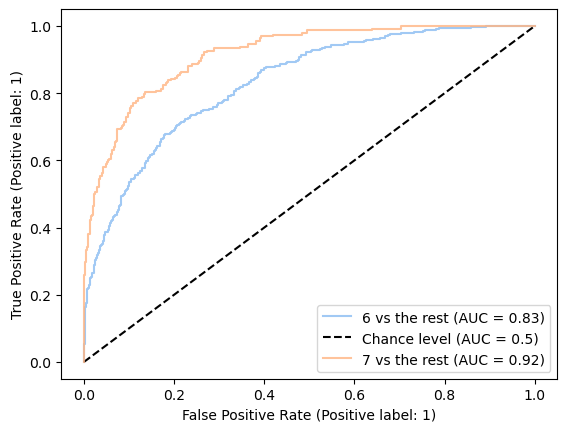

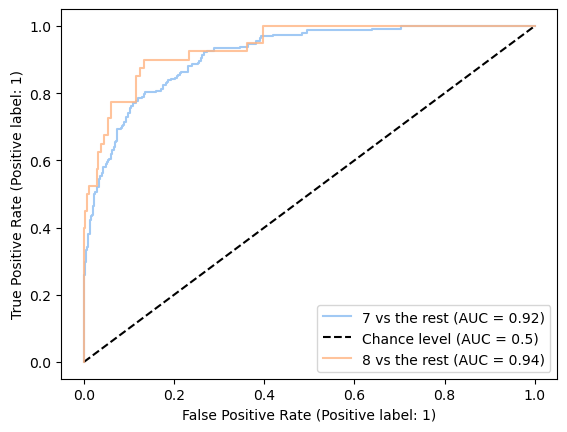

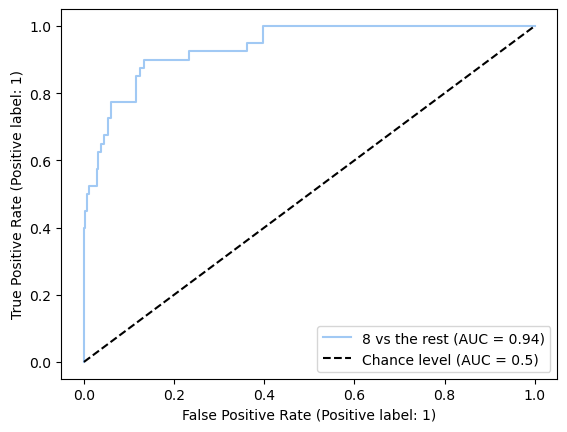

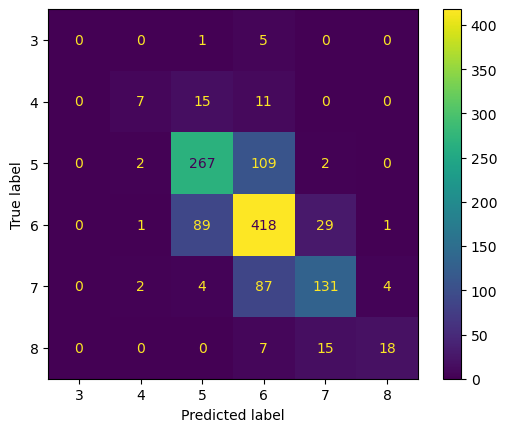

Roc_Auc_Score for wine quality 3 is: 0.8122778233524748
Roc_Auc_Score for wine quality 4 is: 0.8724832214765101
Roc_Auc_Score for wine quality 5 is: 0.882556835876674
Roc_Auc_Score for wine quality 6 is: 0.8277192469819212
Roc_Auc_Score for wine quality 7 is: 0.9164687043586902
Roc_Auc_Score for wine quality 8 is: 0.9426793248945148


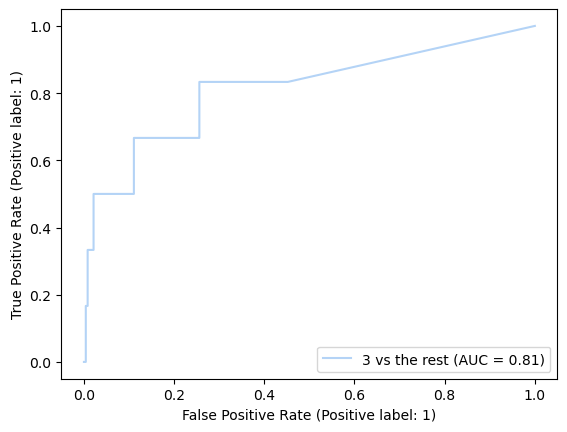

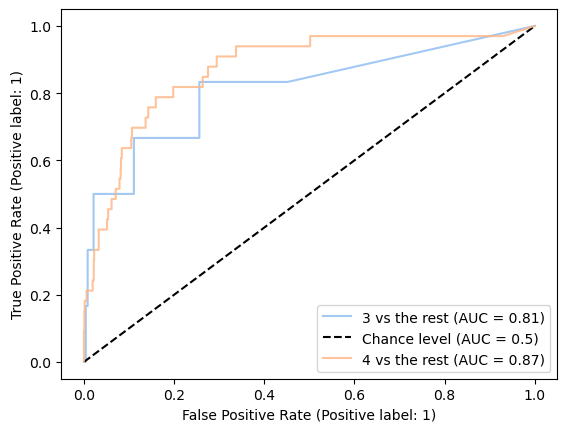

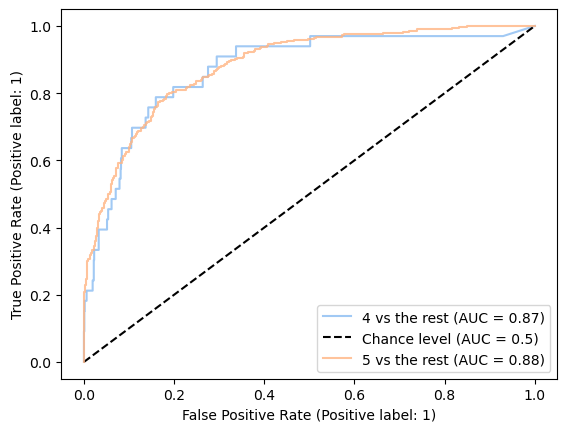

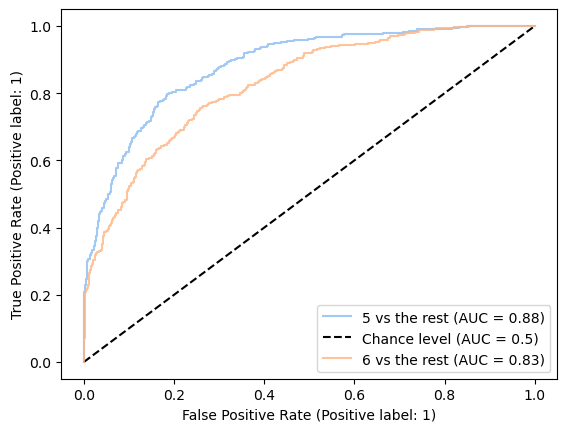

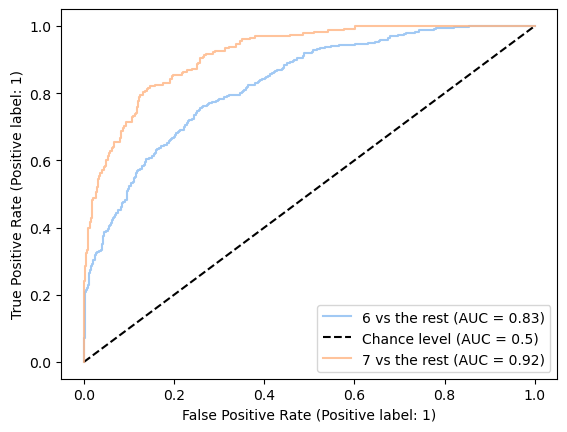

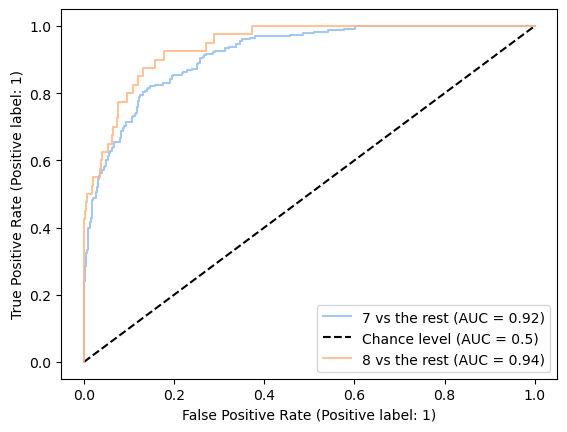

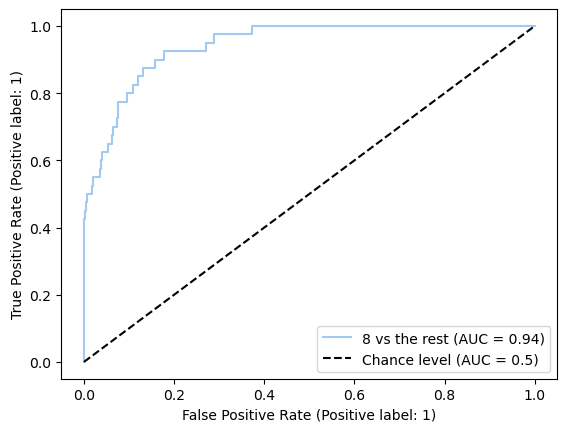

In [17]:
#Try with dumb randomized searcher
rand_searcher = RandomizedSearchCV(rfc, rfcparams, n_jobs=-1, cv=cv)
for a in range(5):
    report_perf(rand_searcher, X_train, y_train, X_test, y_test, "RandomizedSearchCV", "Full Train Set")

Train Accuracy: 1.0
Test Accuracy: 0.68
RandomizedSearchCV best score post refit: 0.6444204711857495
best params: {'weights': 'distance', 'n_neighbors': 50, 'n_jobs': -1, 'leaf_size': 20, 'algorithm': 'ball_tree'}
Total Mean Time for ML (in seconds):  2.177717924118042


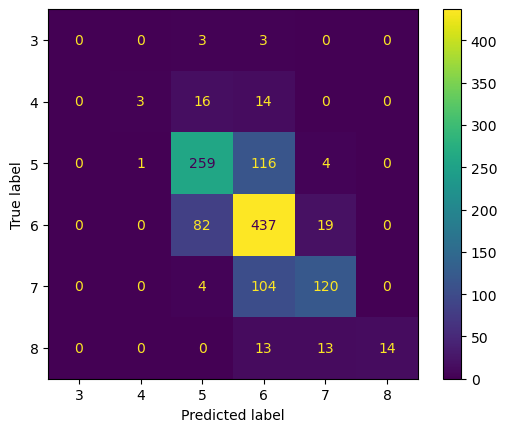

Roc_Auc_Score for wine quality 3 is: 0.6473885698660103
Roc_Auc_Score for wine quality 4 is: 0.8755592841163311
Roc_Auc_Score for wine quality 5 is: 0.8865478044222984
Roc_Auc_Score for wine quality 6 is: 0.8298296023332954
Roc_Auc_Score for wine quality 7 is: 0.9113964701120907
Roc_Auc_Score for wine quality 8 is: 0.9347257383966244
Train Accuracy: 1.0
Test Accuracy: 0.6775510204081633
RandomizedSearchCV best score post refit: 0.6476880016311701
best params: {'weights': 'distance', 'n_neighbors': 25, 'n_jobs': -1, 'leaf_size': 40, 'algorithm': 'auto'}
Total Mean Time for ML (in seconds):  3.2940030097961426


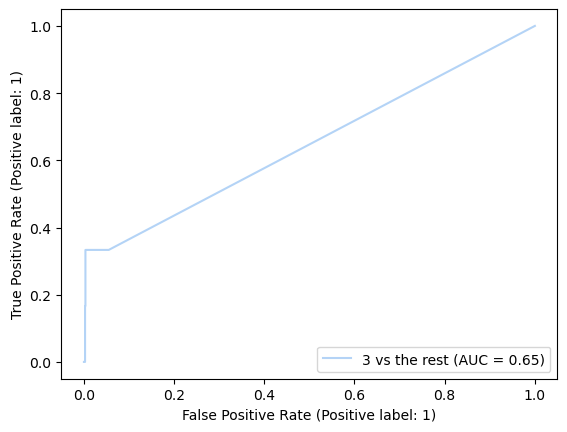

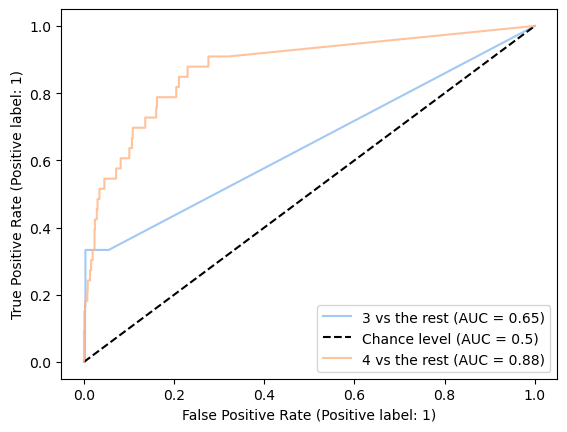

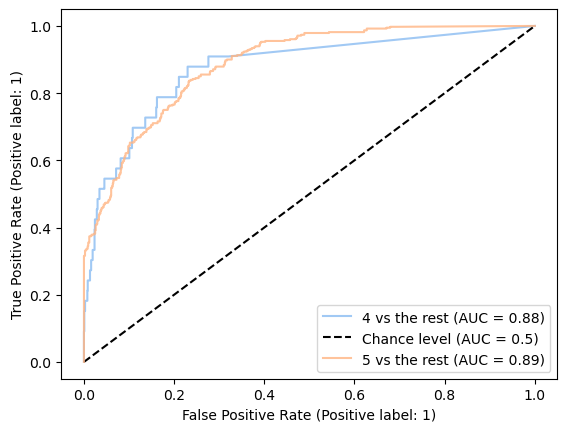

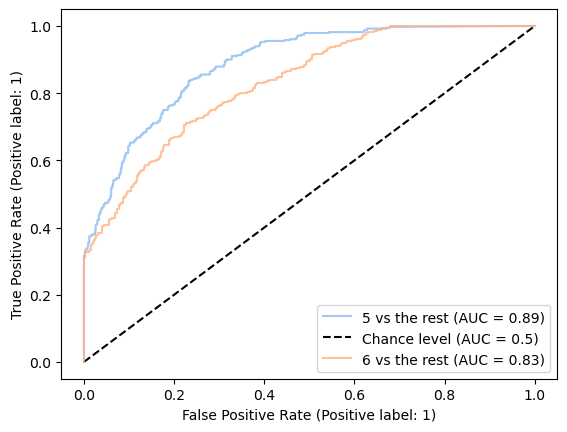

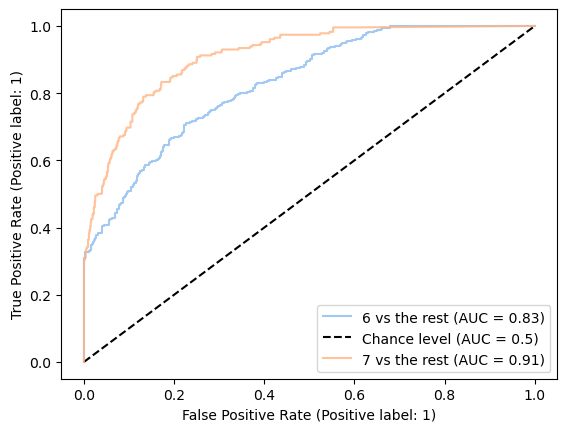

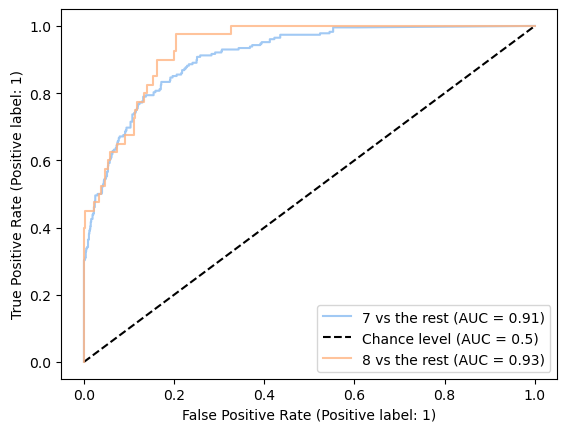

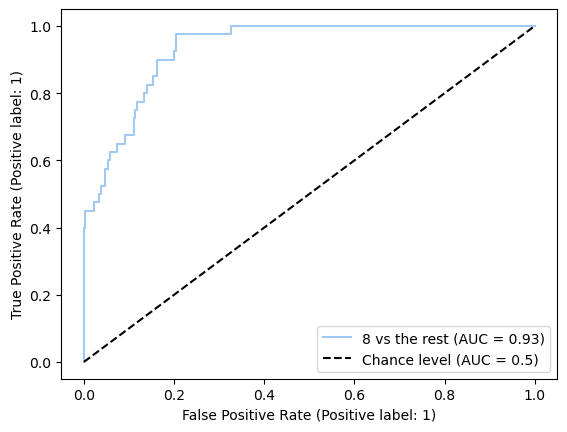

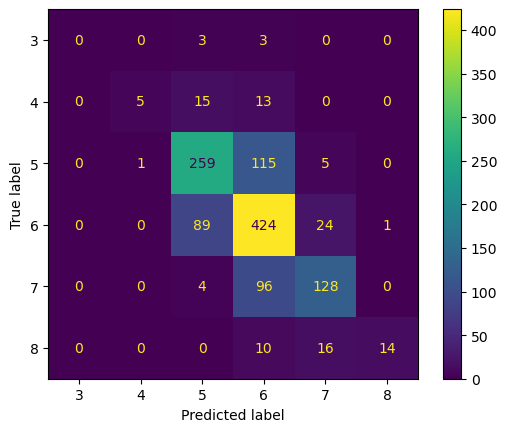

Roc_Auc_Score for wine quality 3 is: 0.5710965272080941
Roc_Auc_Score for wine quality 4 is: 0.8391295505389464
Roc_Auc_Score for wine quality 5 is: 0.8803550295857988
Roc_Auc_Score for wine quality 6 is: 0.8263745718413662
Roc_Auc_Score for wine quality 7 is: 0.9131913283710782
Roc_Auc_Score for wine quality 8 is: 0.9141033755274262
Train Accuracy: 1.0
Test Accuracy: 0.68
RandomizedSearchCV best score post refit: 0.6444204711857495
best params: {'weights': 'distance', 'n_neighbors': 50, 'n_jobs': -1, 'leaf_size': 40, 'algorithm': 'kd_tree'}
Total Mean Time for ML (in seconds):  2.3680524826049805


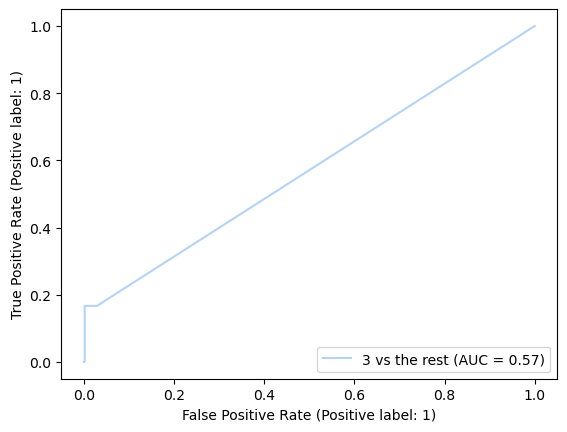

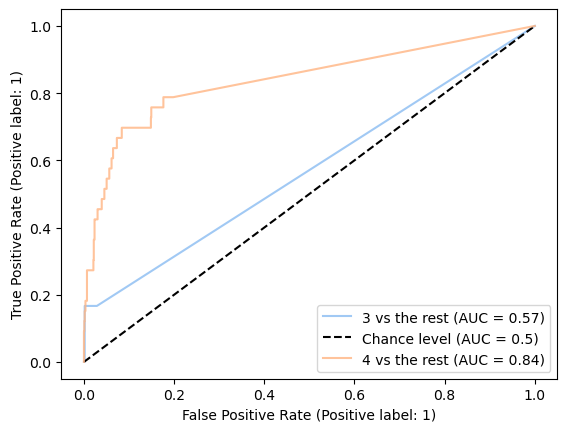

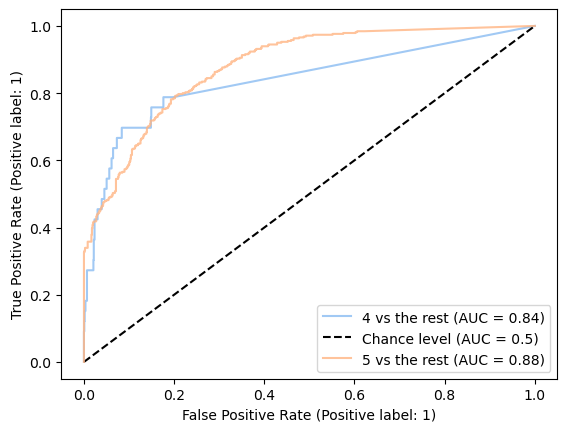

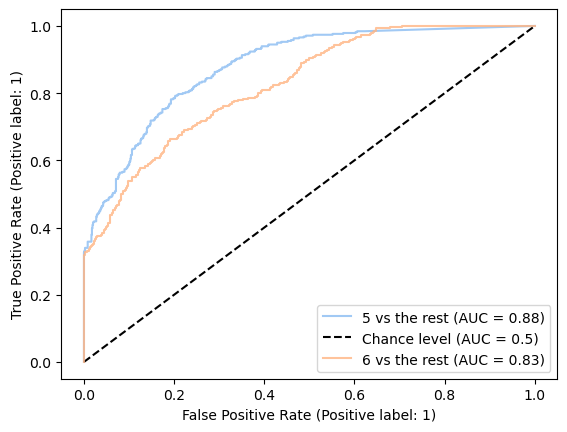

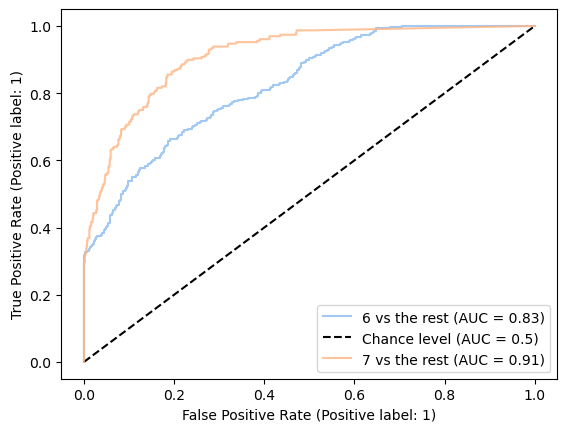

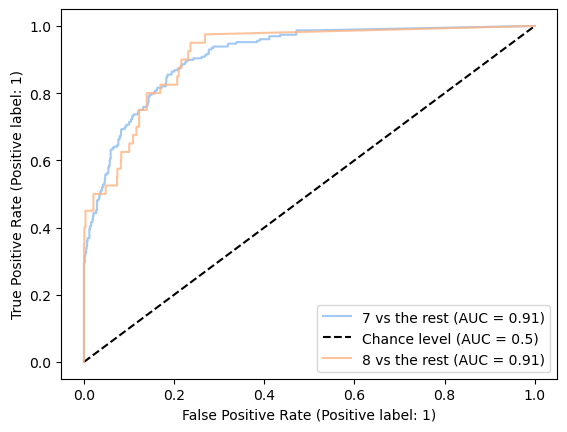

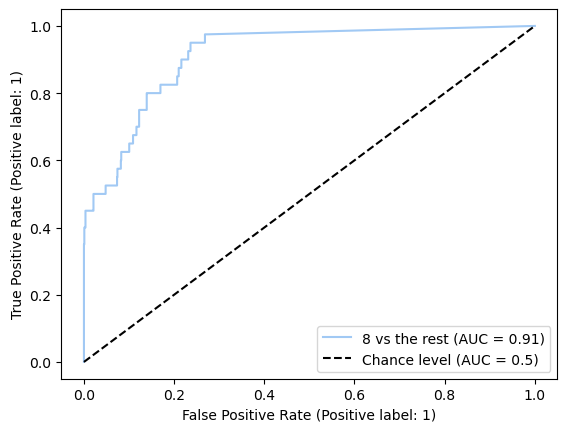

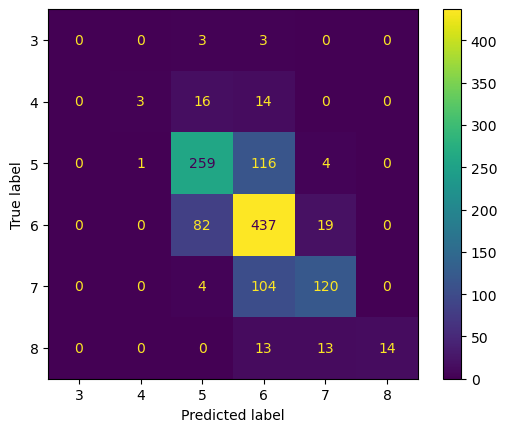

Roc_Auc_Score for wine quality 3 is: 0.6473885698660103
Roc_Auc_Score for wine quality 4 is: 0.8755592841163311
Roc_Auc_Score for wine quality 5 is: 0.8865478044222984
Roc_Auc_Score for wine quality 6 is: 0.8298296023332954
Roc_Auc_Score for wine quality 7 is: 0.9113964701120907
Roc_Auc_Score for wine quality 8 is: 0.9347257383966244
Train Accuracy: 1.0
Test Accuracy: 0.6775510204081633
RandomizedSearchCV best score post refit: 0.6476880016311701
best params: {'weights': 'distance', 'n_neighbors': 25, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Total Mean Time for ML (in seconds):  2.9388377666473393


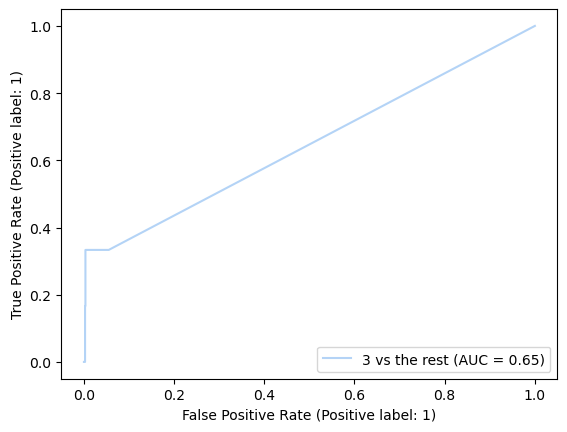

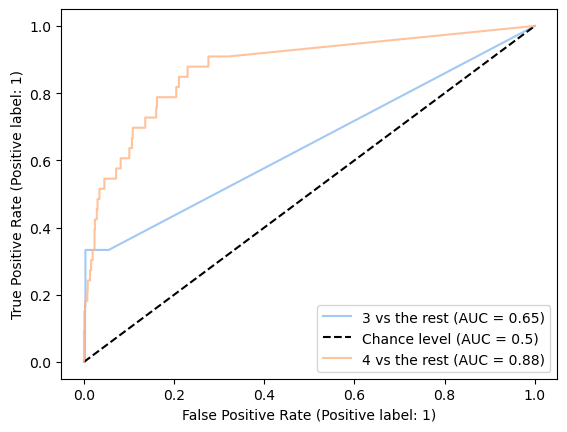

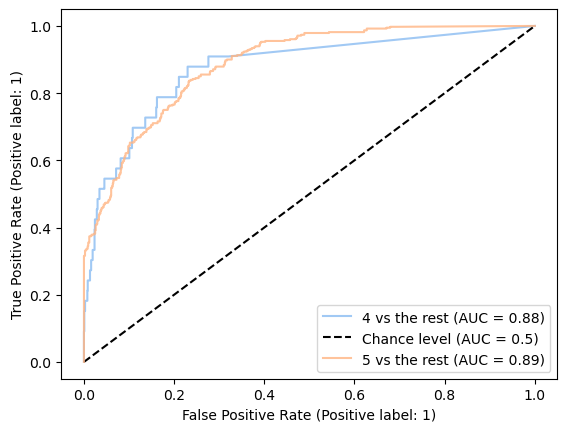

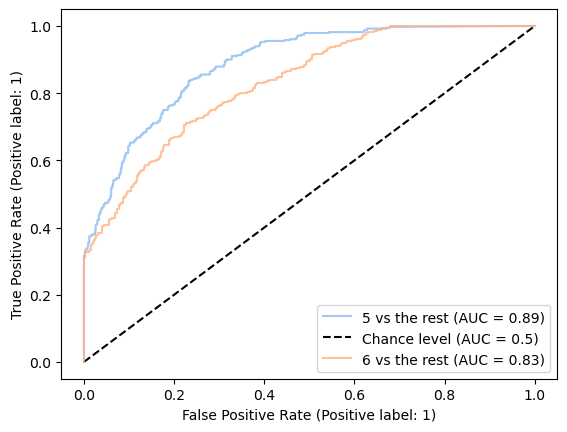

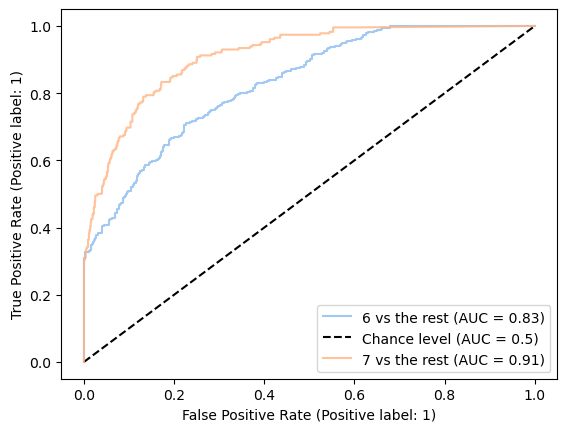

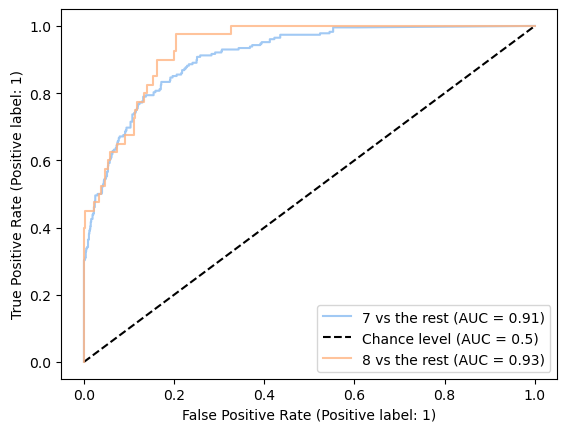

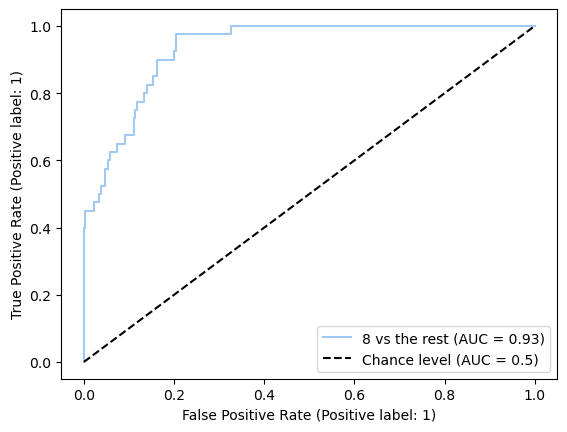

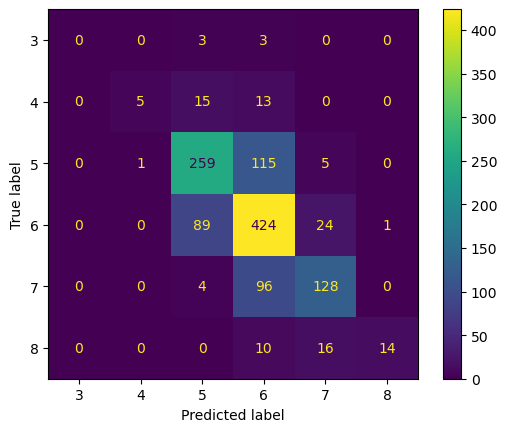

Roc_Auc_Score for wine quality 3 is: 0.5710965272080941
Roc_Auc_Score for wine quality 4 is: 0.8391295505389464
Roc_Auc_Score for wine quality 5 is: 0.8803550295857988
Roc_Auc_Score for wine quality 6 is: 0.8263745718413662
Roc_Auc_Score for wine quality 7 is: 0.9131913283710782
Roc_Auc_Score for wine quality 8 is: 0.9141033755274262
Train Accuracy: 1.0
Test Accuracy: 0.6775510204081633
RandomizedSearchCV best score post refit: 0.6476880016311701
best params: {'weights': 'distance', 'n_neighbors': 25, 'n_jobs': -1, 'leaf_size': 50, 'algorithm': 'kd_tree'}
Total Mean Time for ML (in seconds):  2.5955708026885986


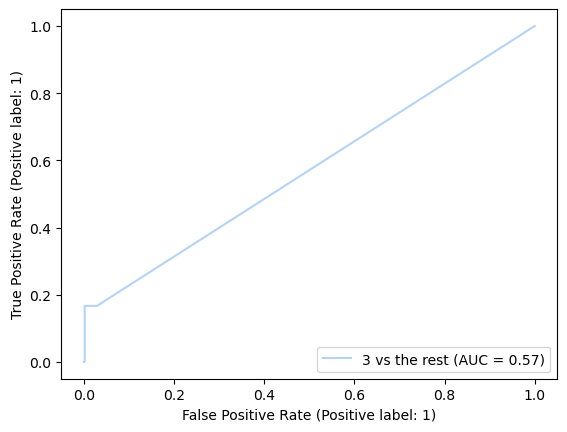

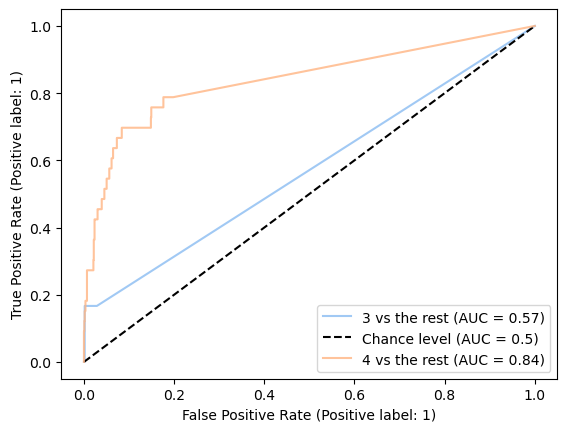

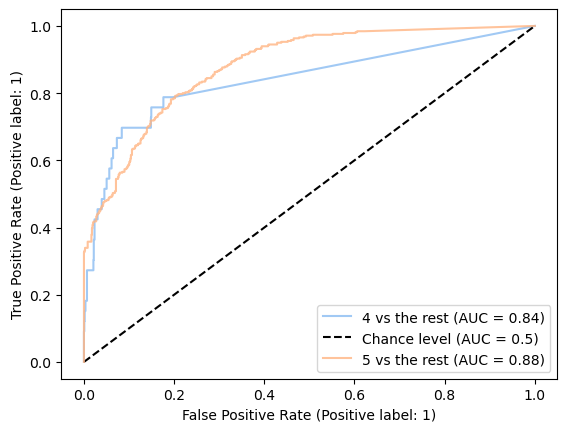

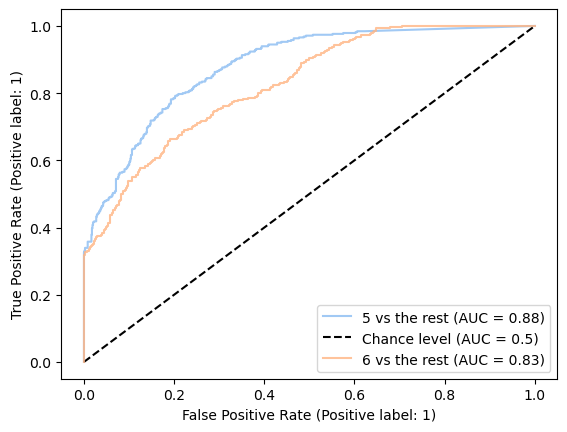

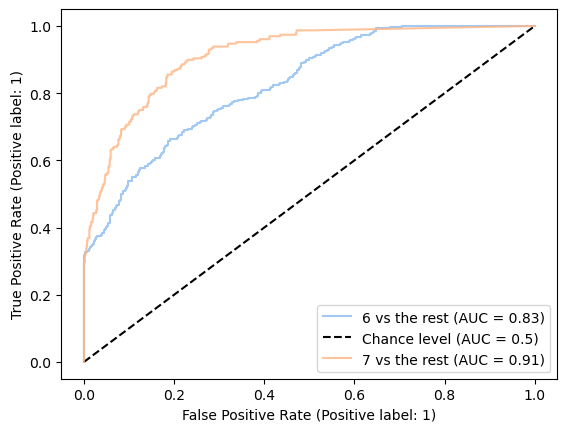

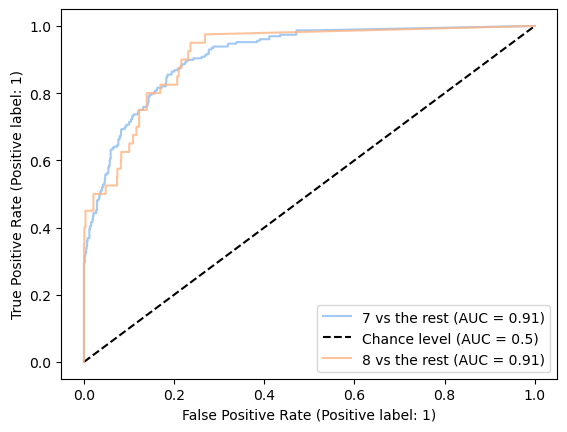

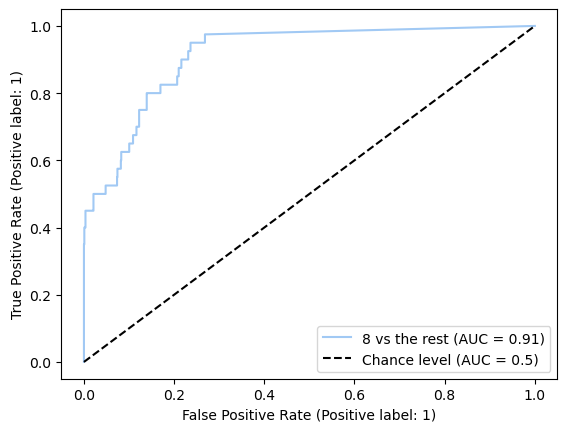

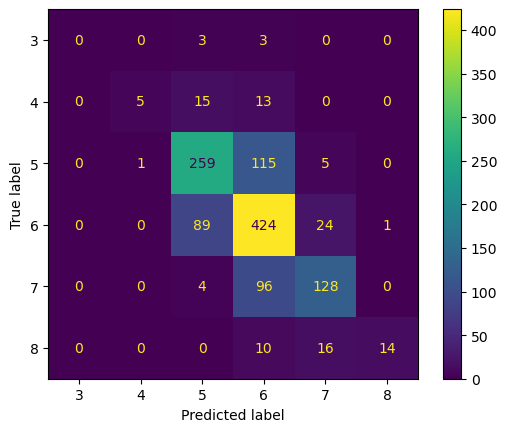

Roc_Auc_Score for wine quality 3 is: 0.5710965272080941
Roc_Auc_Score for wine quality 4 is: 0.8391295505389464
Roc_Auc_Score for wine quality 5 is: 0.8803550295857988
Roc_Auc_Score for wine quality 6 is: 0.8263745718413662
Roc_Auc_Score for wine quality 7 is: 0.9131913283710782
Roc_Auc_Score for wine quality 8 is: 0.9141033755274262


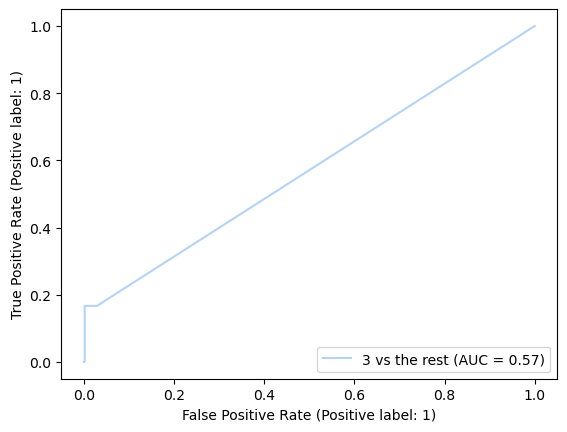

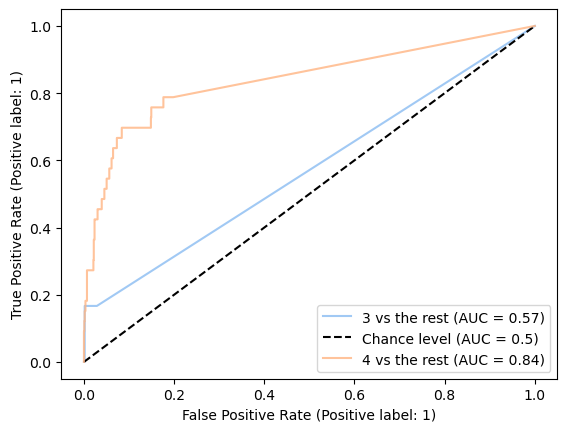

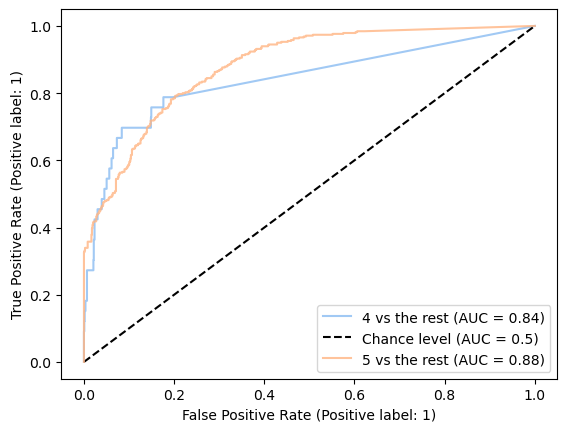

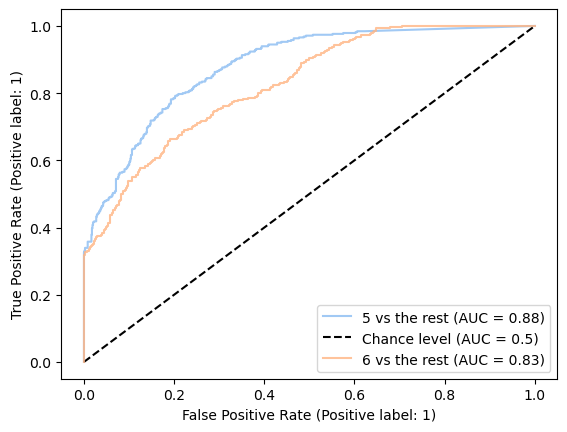

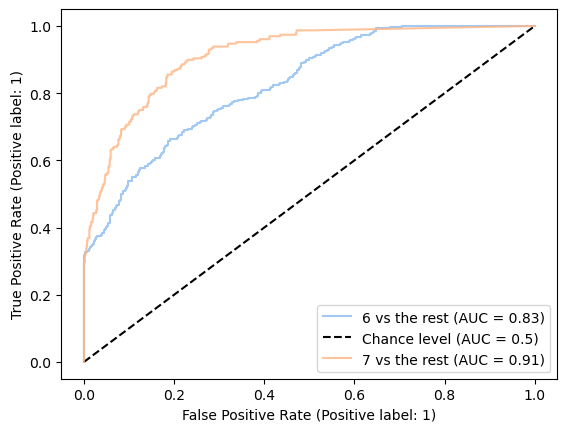

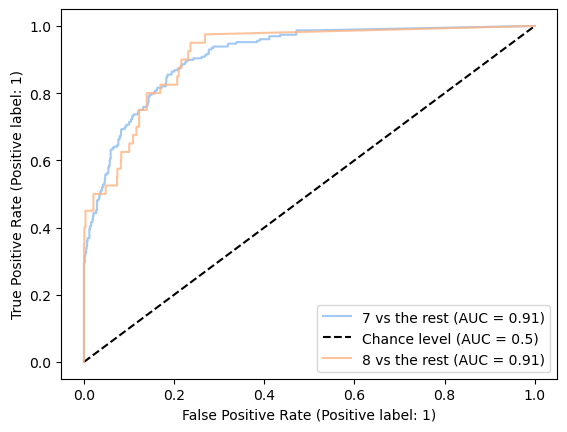

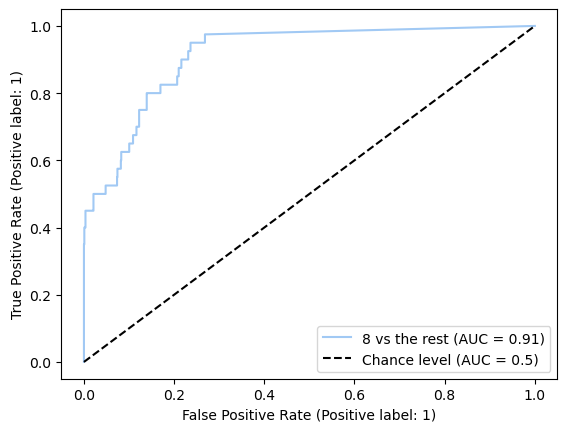

In [18]:
#Try again with knn for dumb randomized searcher
rand_searcher = RandomizedSearchCV(knn, knnparams, n_jobs=-1, cv=cv)
for a in range(5):
    report_perf(rand_searcher, X_train, y_train, X_test, y_test, "RandomizedSearchCV", "Full Train Set")

In [19]:
#Incorporate meta-learning on smaller subsets'
sample_wine = pd.read_csv("winequality-white.csv",sep=';').sample(frac=0.25)
sample_labels = sample_wine.pop('quality')

X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(sample_wine, sample_labels, random_state=0)

Train Accuracy: 0.9989106753812637
Test Accuracy: 0.5522875816993464
BayesSearchCV best score post refit: 0.5577809455927774
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced'), ('criterion', 'log_loss'), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  166.6690845489502


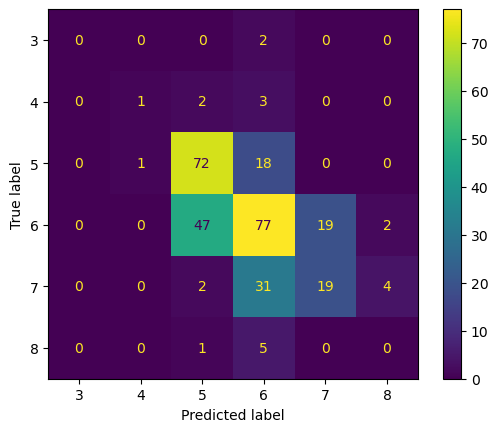

Roc_Auc_Score for wine quality 3 is: 0.6685855263157896
Roc_Auc_Score for wine quality 4 is: 0.725
Roc_Auc_Score for wine quality 5 is: 0.8453360592895477
Roc_Auc_Score for wine quality 6 is: 0.6517027200685372
Roc_Auc_Score for wine quality 7 is: 0.8367857142857142
Roc_Auc_Score for wine quality 8 is: 0.7055555555555555
Train Accuracy: 0.9989106753812637
Test Accuracy: 0.4869281045751634
BayesSearchCV best score post refit: 0.5370159182703731
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'log_loss'), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  173.2055296897888


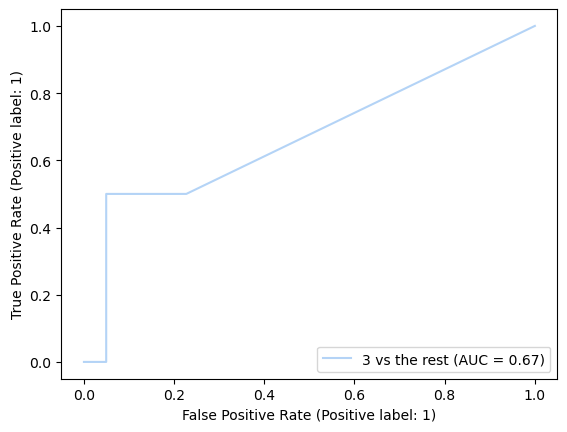

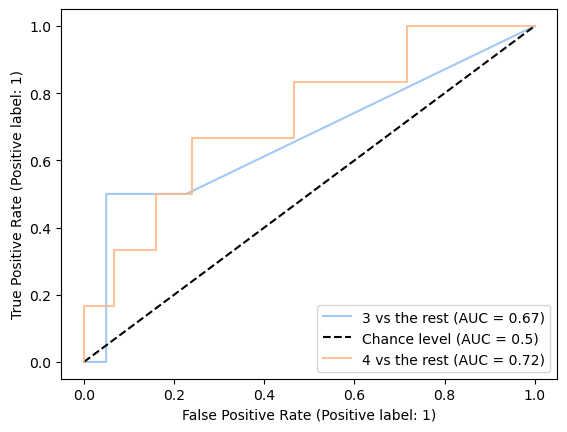

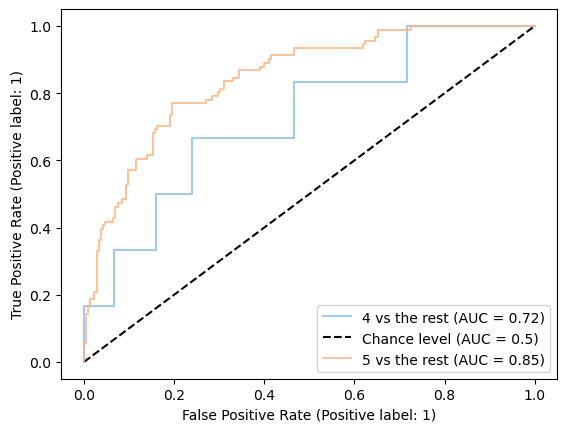

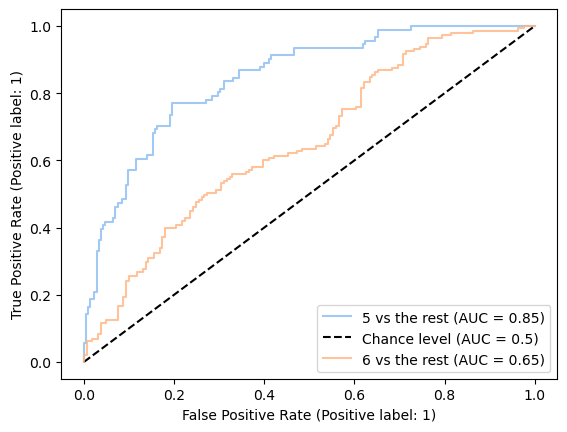

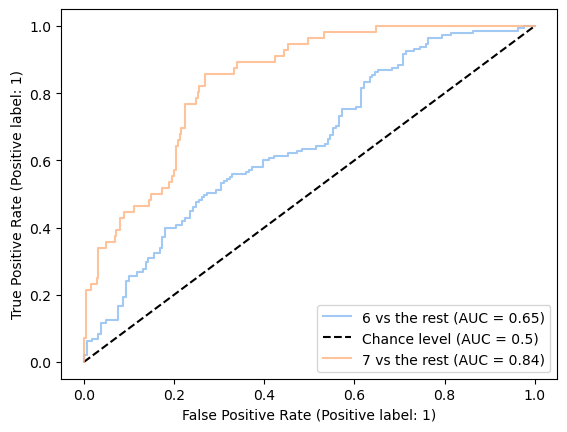

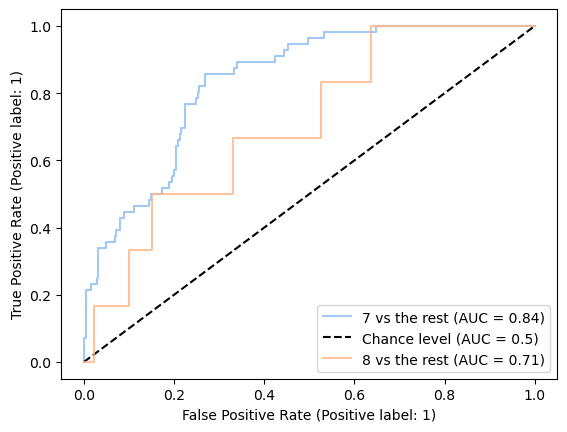

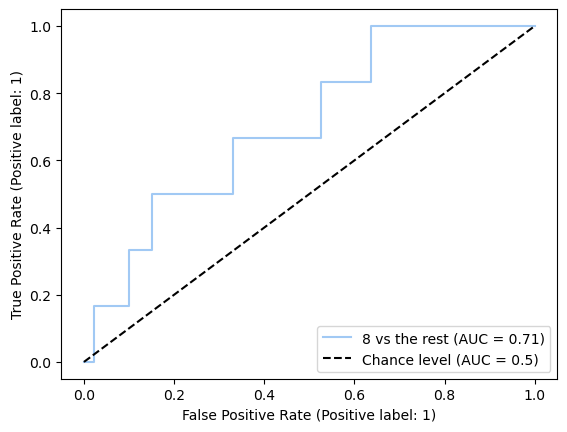

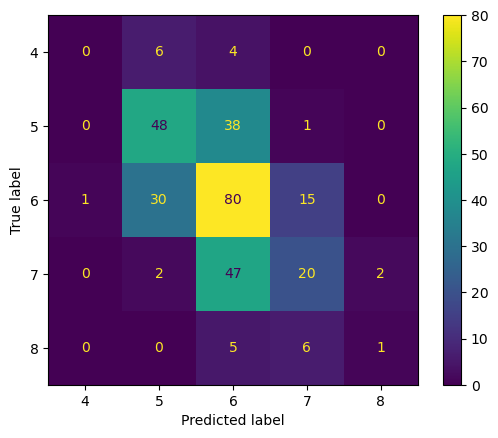

Oh well, I cant do this for whatever reason
Roc_Auc_Score for wine quality 4 is: 0.9361486486486487
Roc_Auc_Score for wine quality 5 is: 0.8226526006403191
Roc_Auc_Score for wine quality 6 is: 0.6346560846560847
Roc_Auc_Score for wine quality 7 is: 0.8453700928978124
Roc_Auc_Score for wine quality 8 is: 0.8154761904761905
Train Accuracy: 1.0
Test Accuracy: 0.5882352941176471
BayesSearchCV best score post refit: 0.6078819196958898
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  175.6535766124725


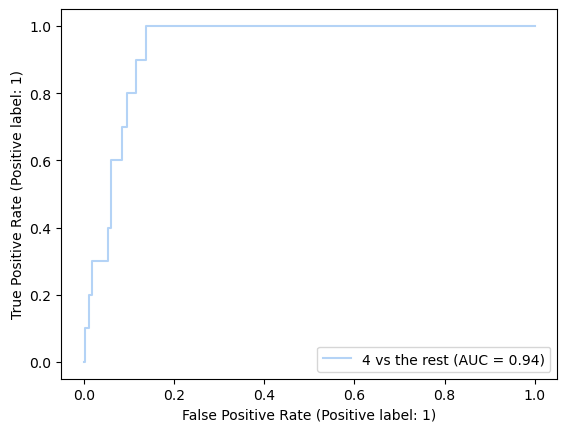

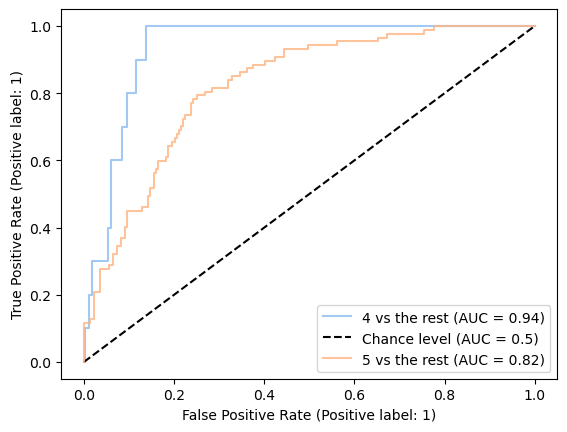

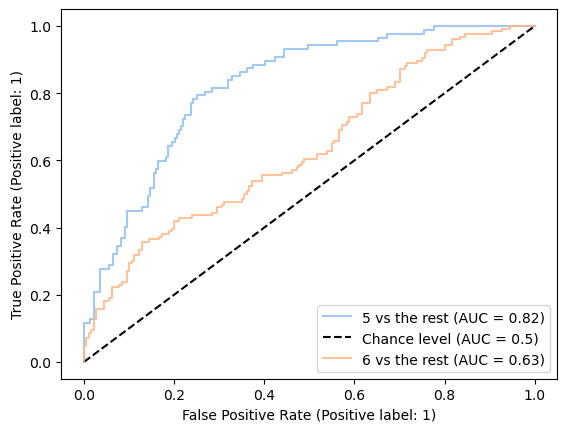

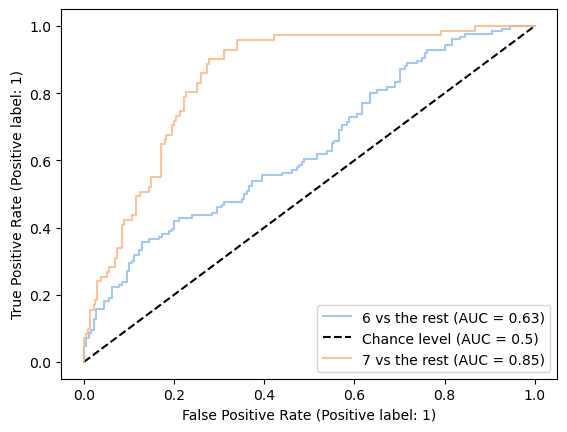

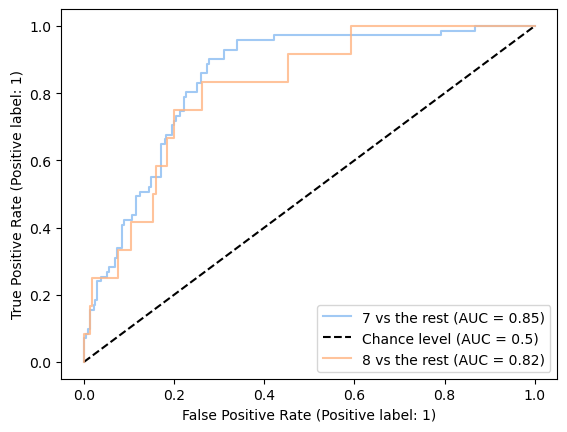

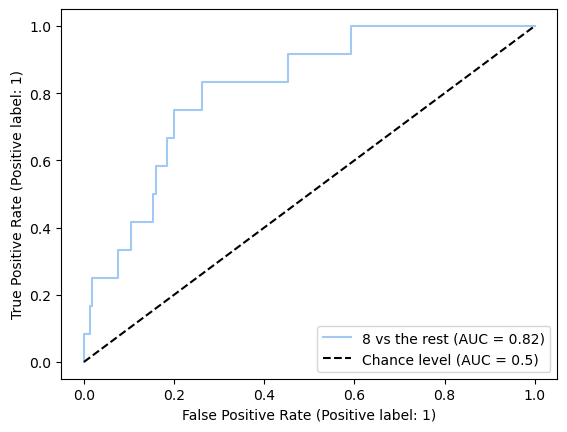

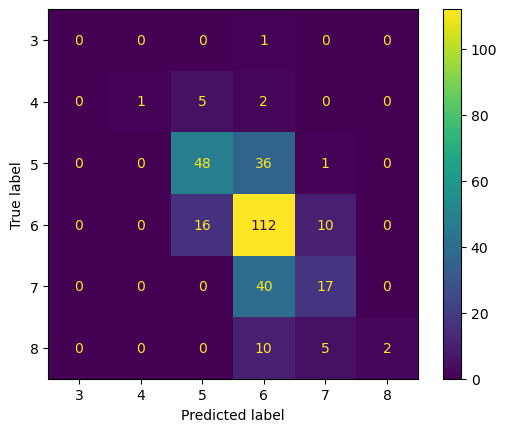

Roc_Auc_Score for wine quality 3 is: 0.4245901639344262
Roc_Auc_Score for wine quality 4 is: 0.8208892617449663
Roc_Auc_Score for wine quality 5 is: 0.8428267234495608
Roc_Auc_Score for wine quality 6 is: 0.6975931677018634
Roc_Auc_Score for wine quality 7 is: 0.7940181779750581
Roc_Auc_Score for wine quality 8 is: 0.6808467331569306
Train Accuracy: 0.9978213507625272
Test Accuracy: 0.5718954248366013
BayesSearchCV best score post refit: 0.6165359942979329
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'log_loss'), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 5), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  178.25745034217834


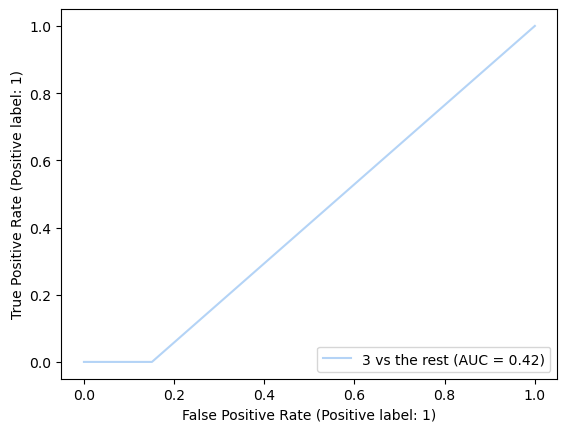

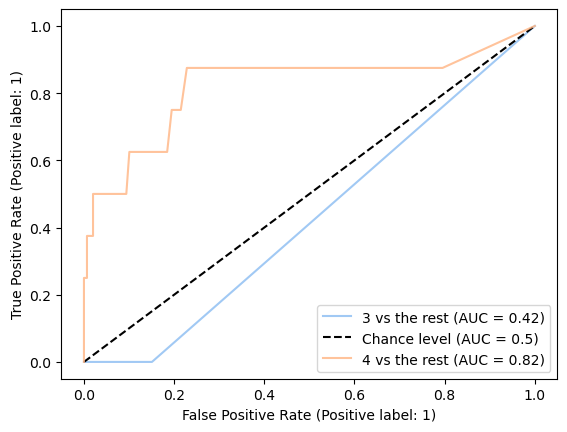

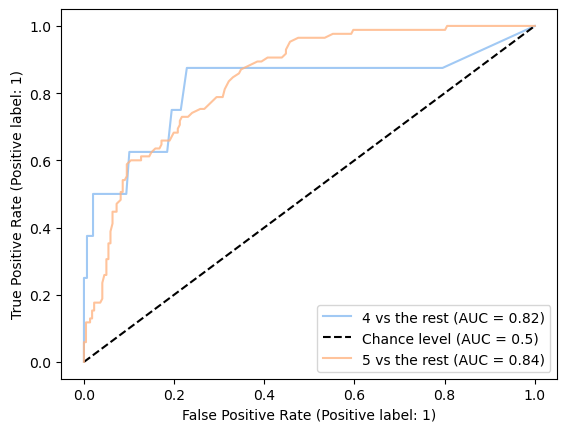

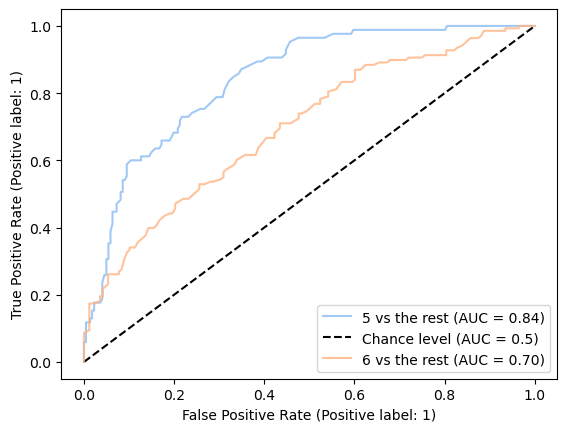

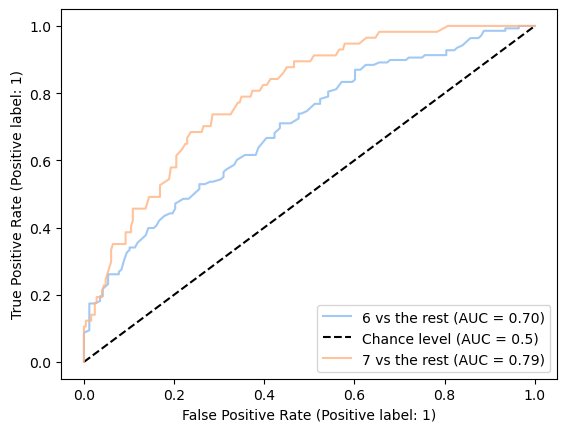

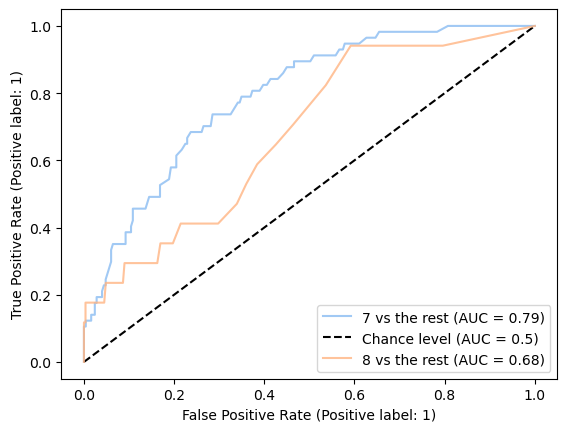

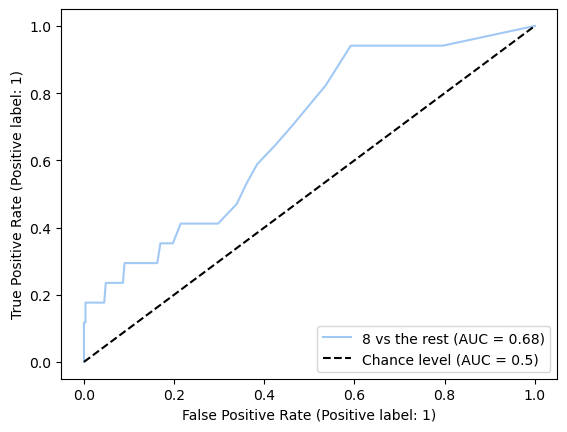

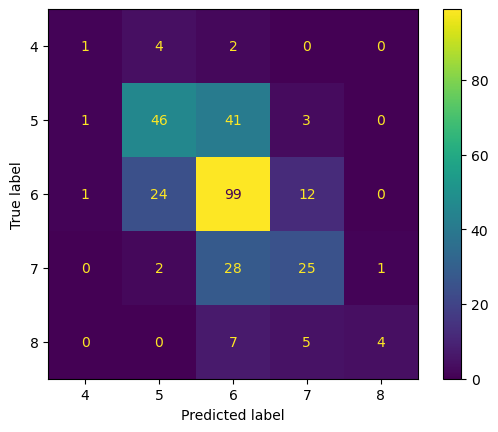

Oh well, I cant do this for whatever reason
Roc_Auc_Score for wine quality 4 is: 0.8437649307214525
Roc_Auc_Score for wine quality 5 is: 0.7914643496038846
Roc_Auc_Score for wine quality 6 is: 0.6967128027681662
Roc_Auc_Score for wine quality 7 is: 0.847
Roc_Auc_Score for wine quality 8 is: 0.8762931034482758
Train Accuracy: 0.9989106753812637
Test Accuracy: 0.5326797385620915
BayesSearchCV best score post refit: 0.5904252791636969
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'log_loss'), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  170.636821269989


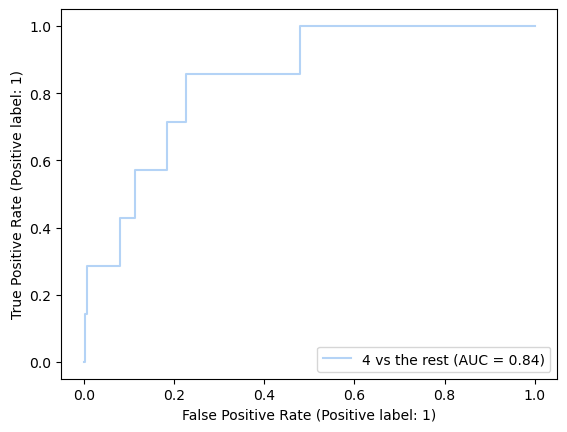

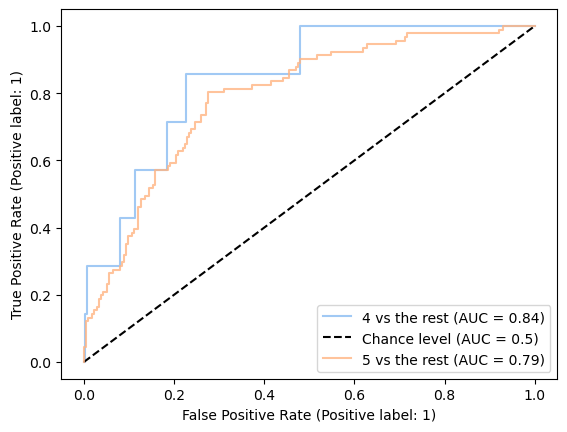

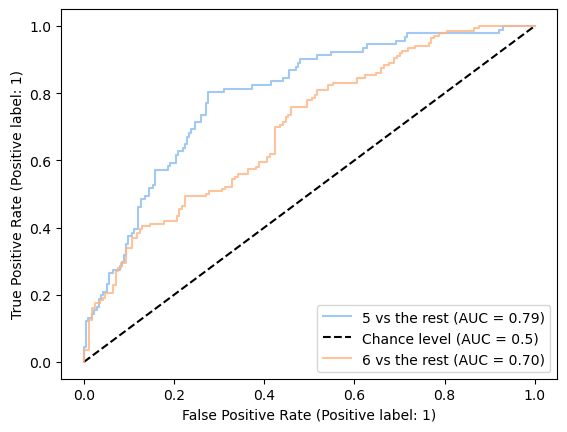

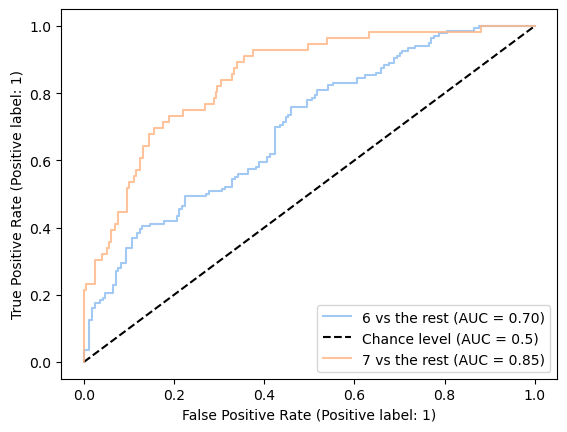

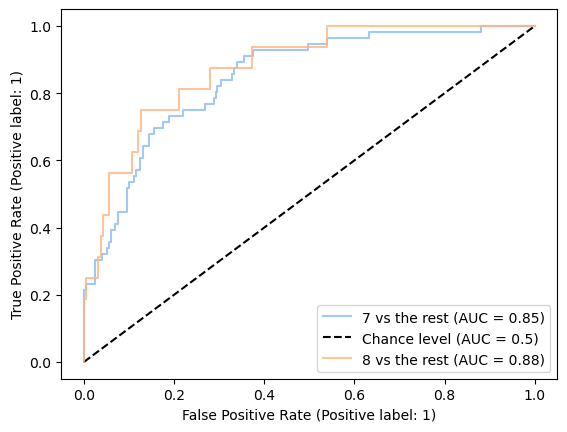

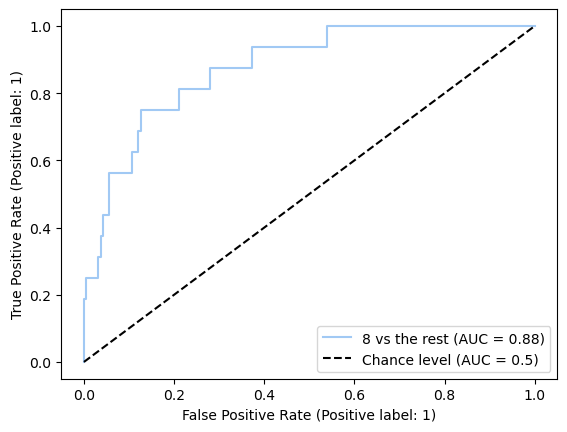

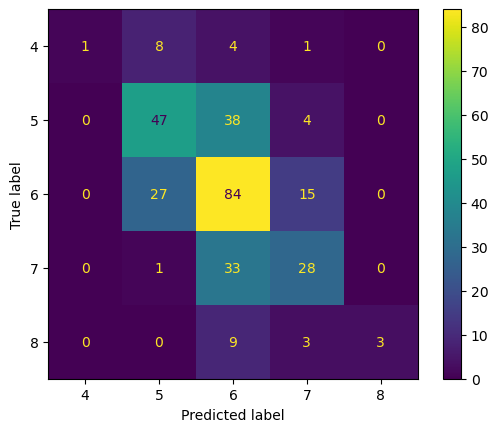

Oh well, I cant do this for whatever reason
Roc_Auc_Score for wine quality 4 is: 0.8069960861056751
Roc_Auc_Score for wine quality 5 is: 0.7704137109718843
Roc_Auc_Score for wine quality 6 is: 0.6638007054673721
Roc_Auc_Score for wine quality 7 is: 0.8537810682178741
Roc_Auc_Score for wine quality 8 is: 0.7326460481099657
Train Accuracy: 1.0
Test Accuracy: 0.5588235294117647
BayesSearchCV best score post refit: 0.5533559040152054
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 5), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  170.89335393905637


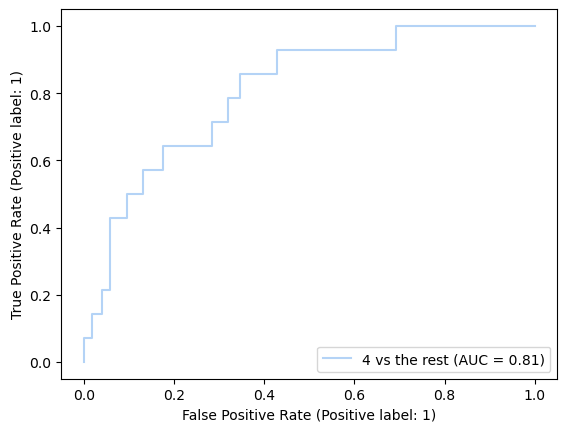

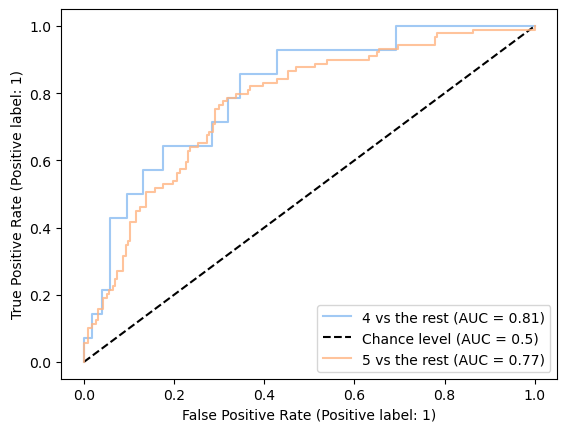

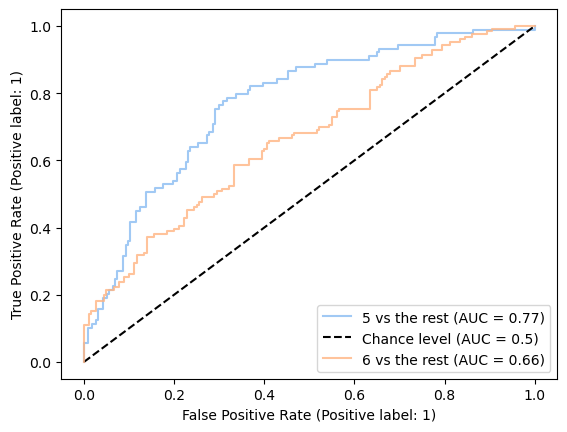

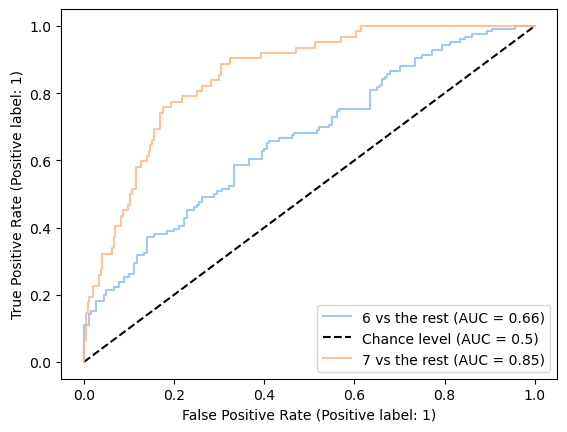

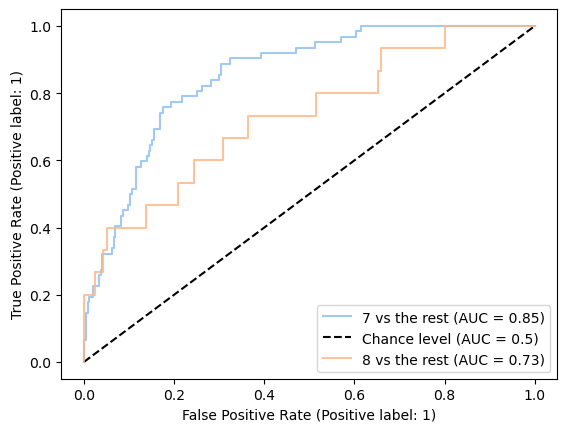

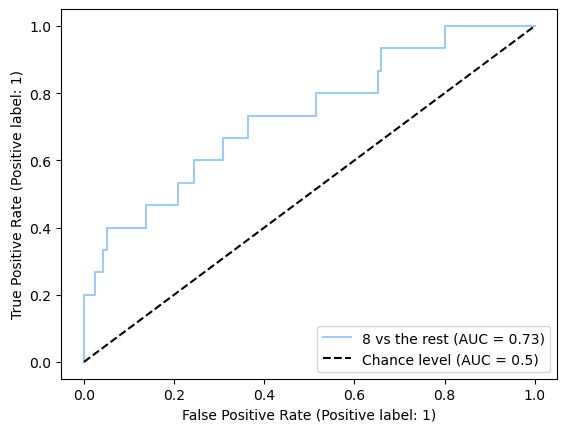

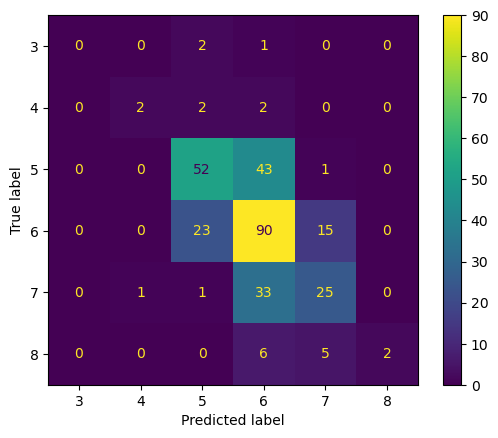

Roc_Auc_Score for wine quality 3 is: 0.5291529152915291
Roc_Auc_Score for wine quality 4 is: 0.9322222222222223
Roc_Auc_Score for wine quality 5 is: 0.8328373015873016
Roc_Auc_Score for wine quality 6 is: 0.6769224016853933
Roc_Auc_Score for wine quality 7 is: 0.8177506775067751
Roc_Auc_Score for wine quality 8 is: 0.8288264636387503
Train Accuracy: 1.0
Test Accuracy: 0.5686274509803921
BayesSearchCV best score post refit: 0.5545319553338086
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 4), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  172.8523442745209


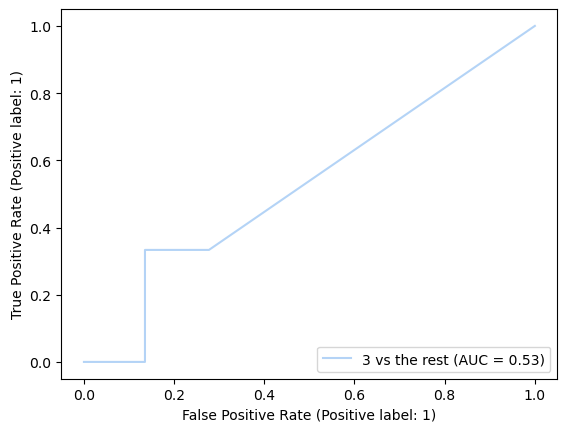

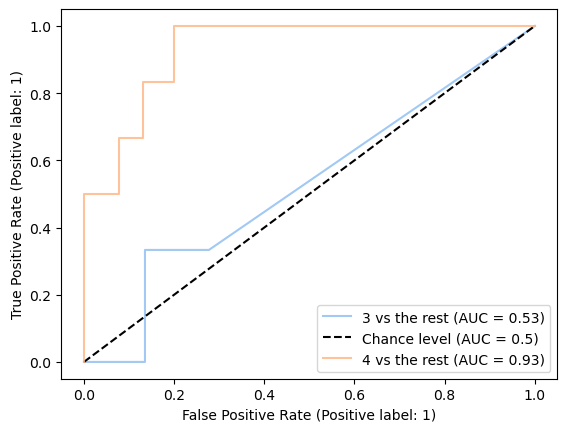

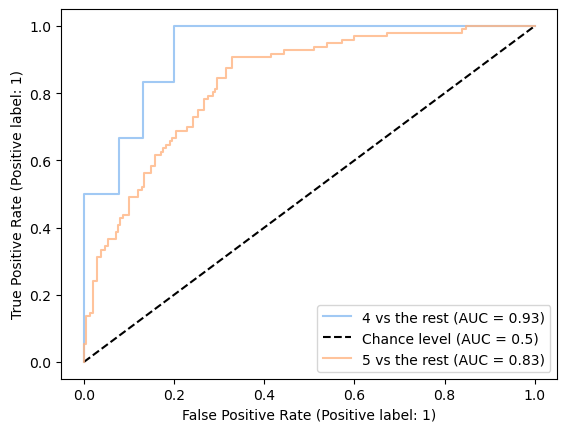

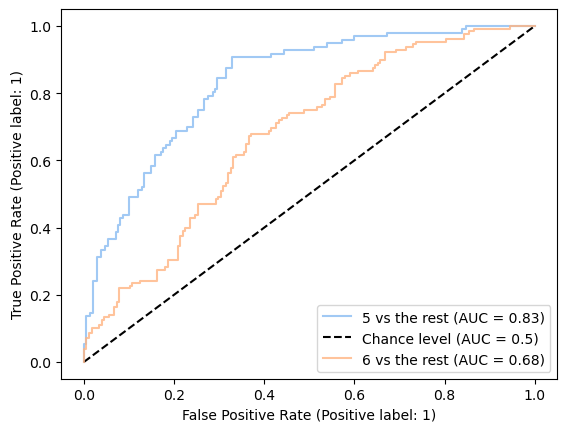

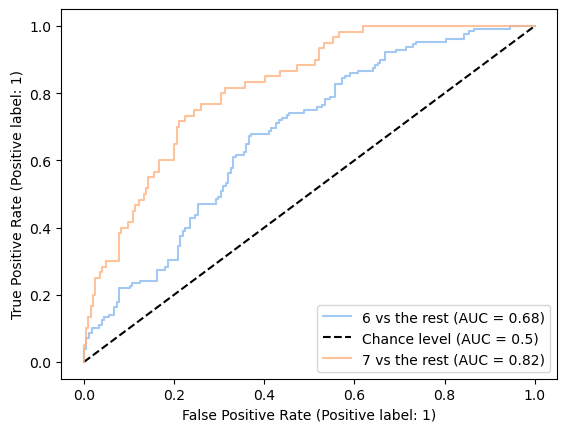

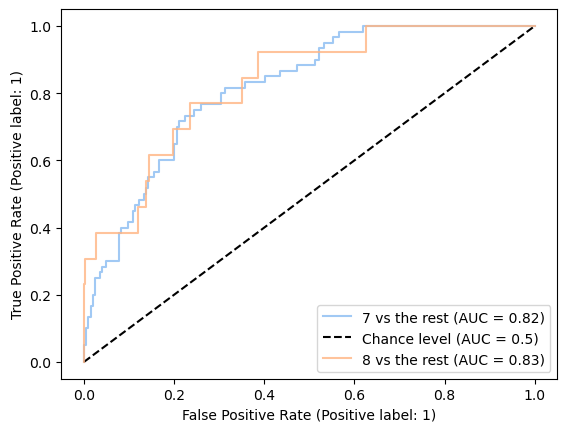

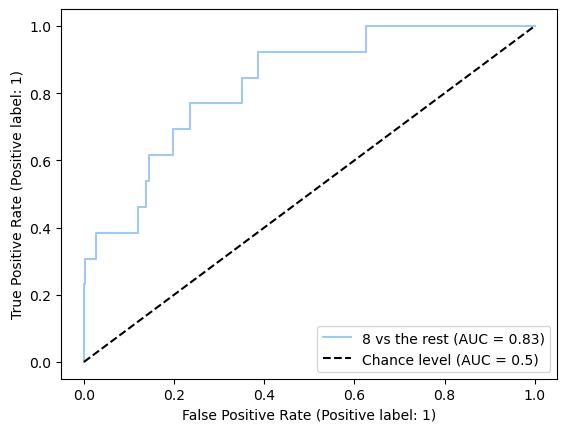

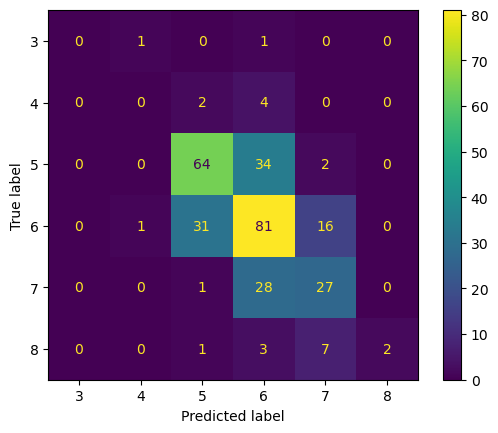

Roc_Auc_Score for wine quality 3 is: 0.9819078947368421
Roc_Auc_Score for wine quality 4 is: 0.8155555555555556
Roc_Auc_Score for wine quality 5 is: 0.8162135922330097
Roc_Auc_Score for wine quality 6 is: 0.6967109008890641
Roc_Auc_Score for wine quality 7 is: 0.8321428571428572
Roc_Auc_Score for wine quality 8 is: 0.8424783407718561
Train Accuracy: 1.0
Test Accuracy: 0.6274509803921569
BayesSearchCV best score post refit: 0.5751425516749821
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  165.55186080932614


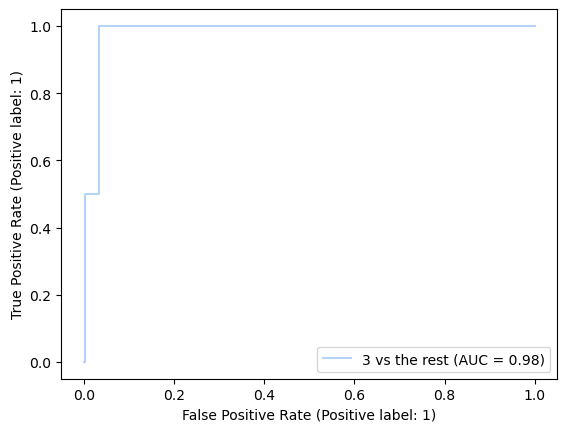

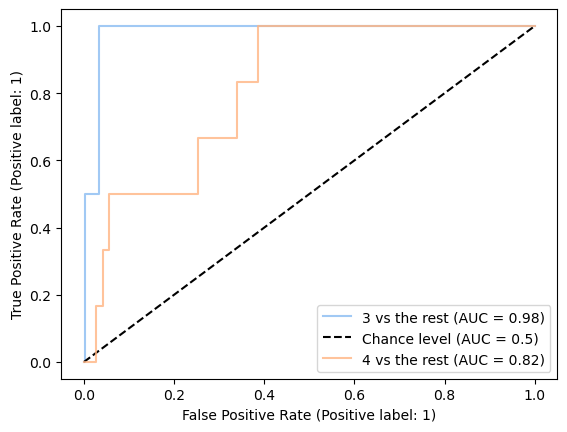

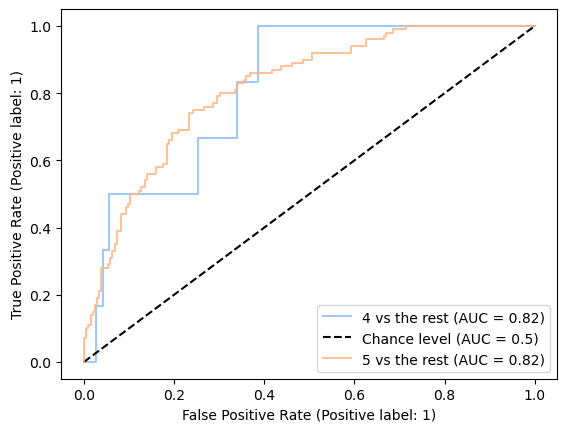

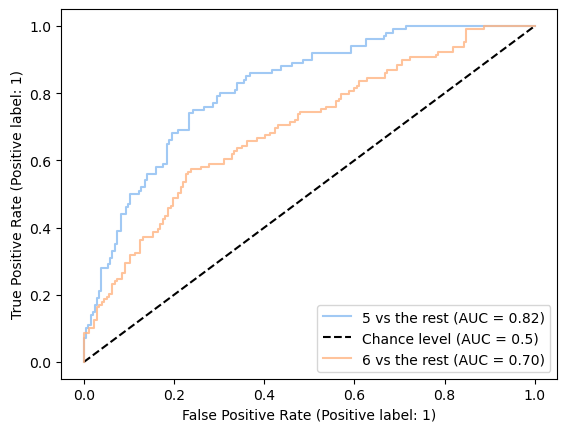

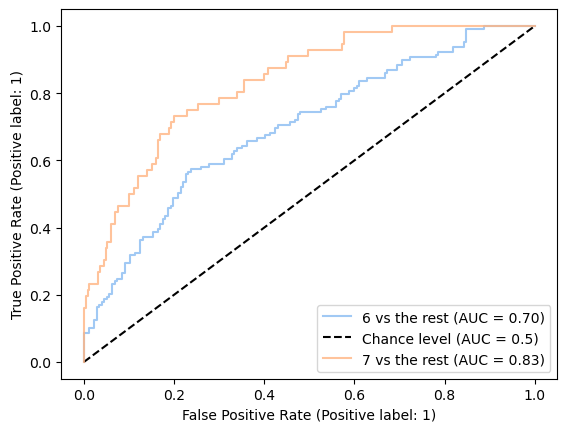

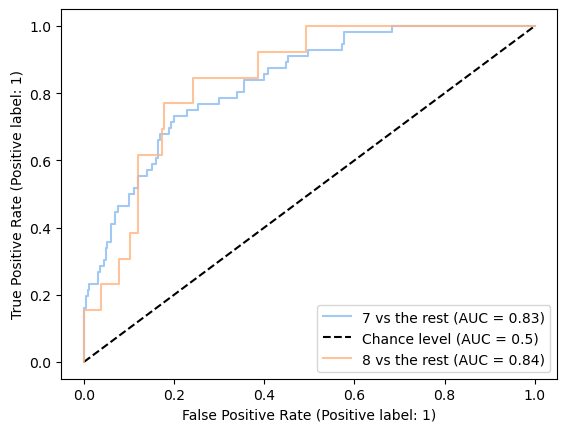

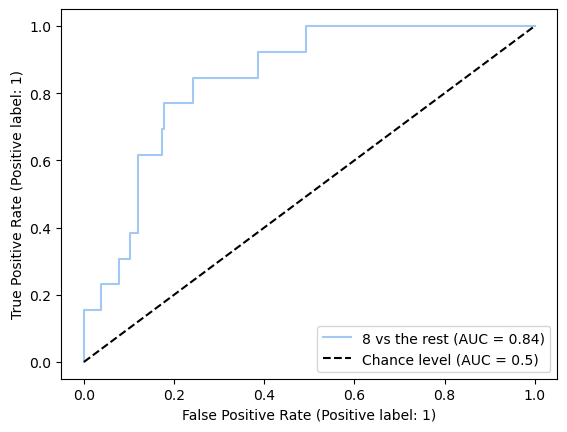

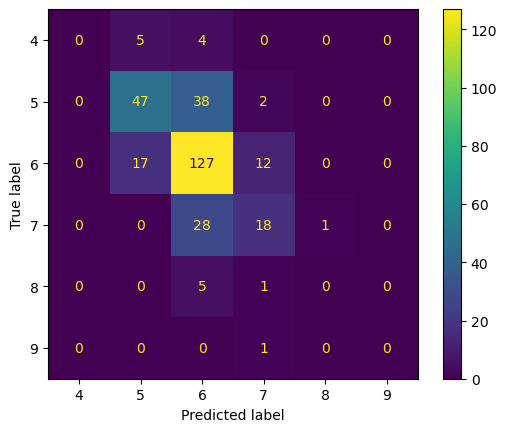

Oh well, I cant do this for whatever reason
Roc_Auc_Score for wine quality 4 is: 0.8583988028432473
Roc_Auc_Score for wine quality 5 is: 0.8551671652758095
Roc_Auc_Score for wine quality 6 is: 0.7164316239316237
Roc_Auc_Score for wine quality 7 is: 0.8500780415674032
Roc_Auc_Score for wine quality 8 is: 0.7636111111111111
Roc_Auc_Score for wine quality 9 is: 0.9557377049180328
Train Accuracy: 1.0
Test Accuracy: 0.5816993464052288
BayesSearchCV best score post refit: 0.5587728676645284
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced'), ('criterion', 'gini'), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  164.21964168548584


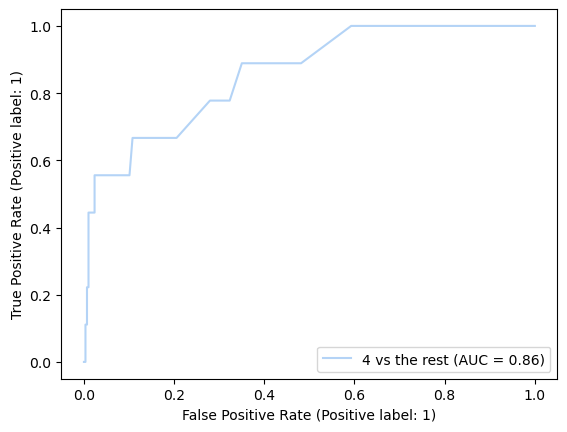

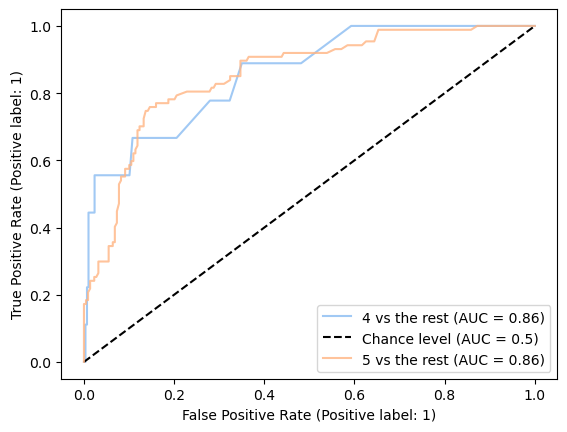

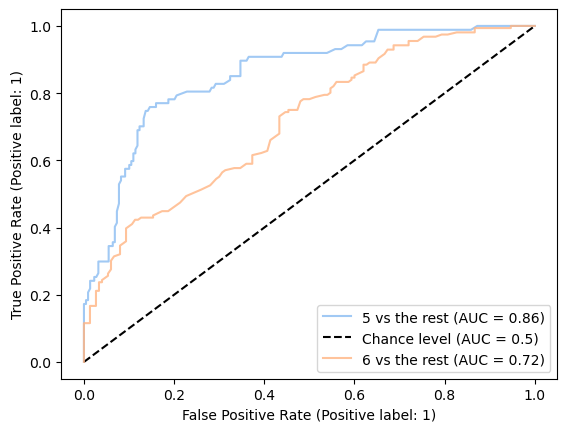

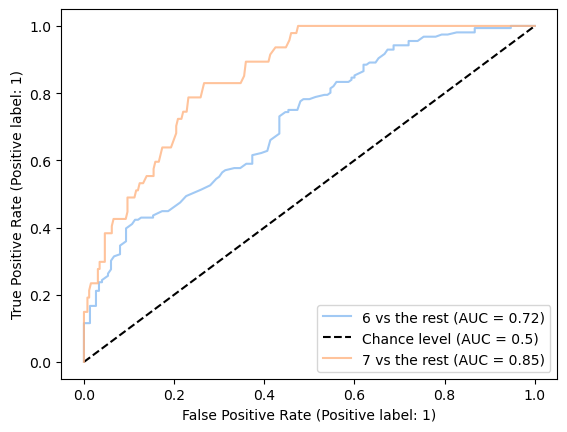

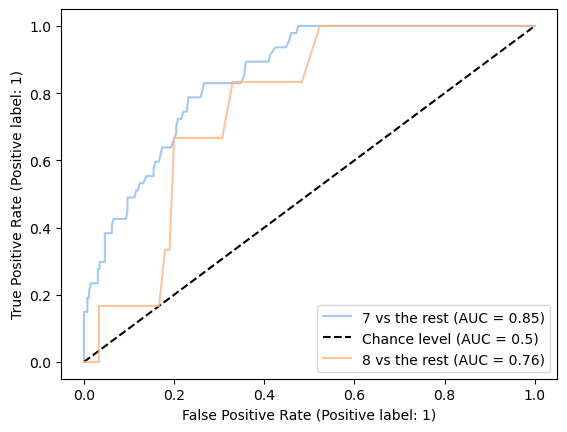

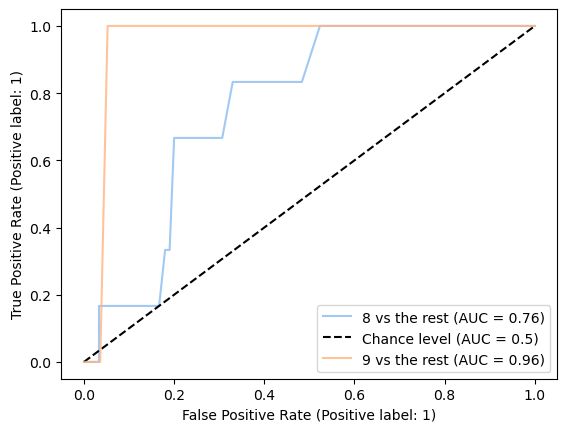

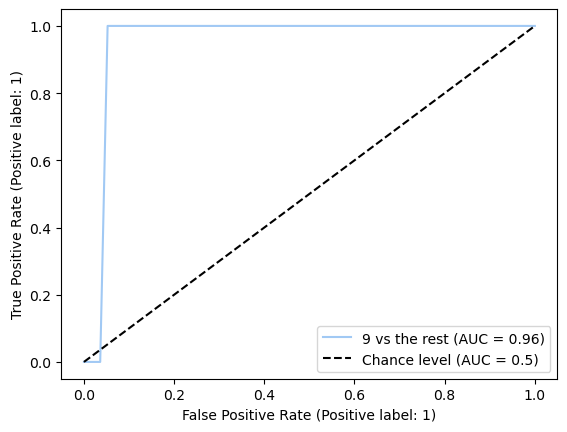

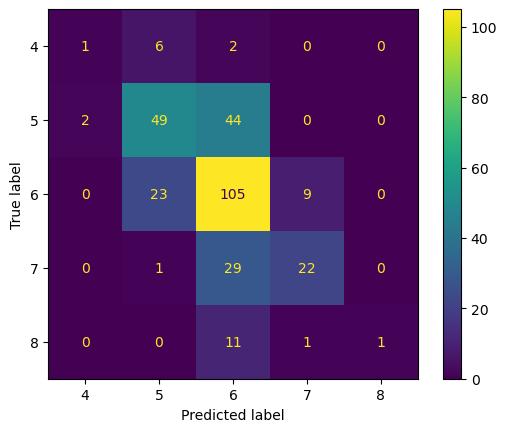

Oh well, I cant do this for whatever reason
Roc_Auc_Score for wine quality 4 is: 0.7717919940142163
Roc_Auc_Score for wine quality 5 is: 0.8306809678223995
Roc_Auc_Score for wine quality 6 is: 0.6708201960869001
Roc_Auc_Score for wine quality 7 is: 0.8298758328285887
Roc_Auc_Score for wine quality 8 is: 0.8138619060120766
Train Accuracy: 1.0
Test Accuracy: 0.5980392156862745
BayesSearchCV best score post refit: 0.5588203848895225
best params: OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 5), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('n_jobs', -1)])
Total Mean Time for ML (in seconds):  169.04938960075376


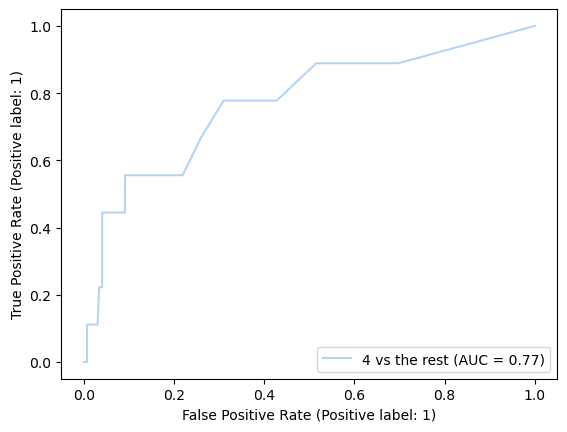

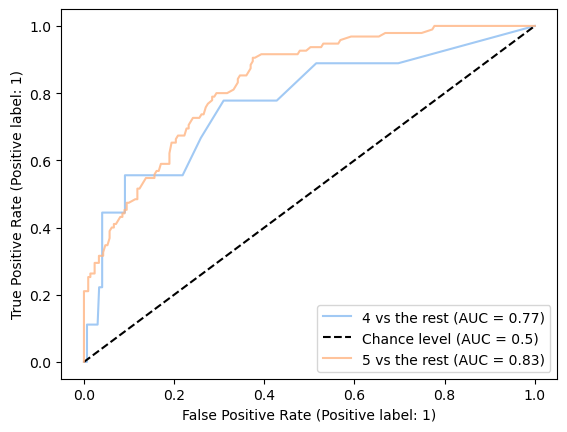

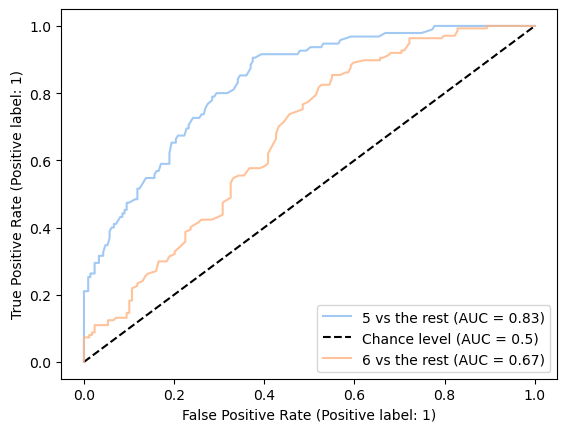

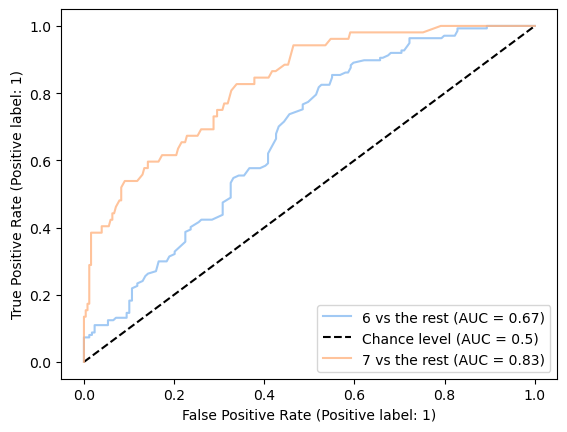

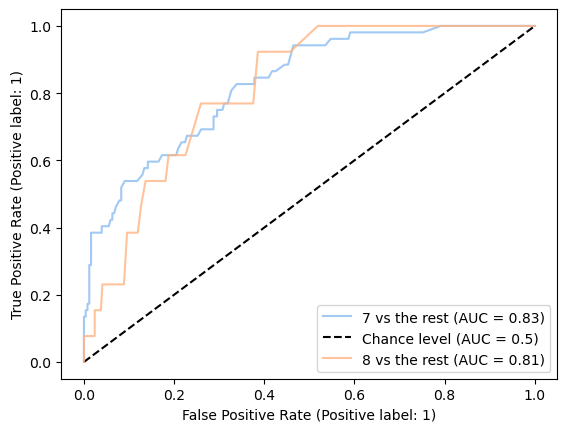

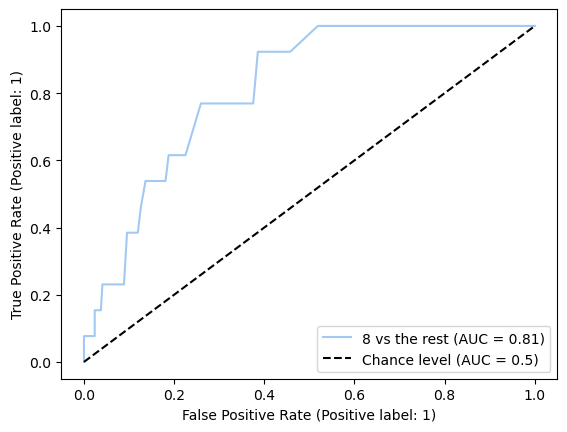

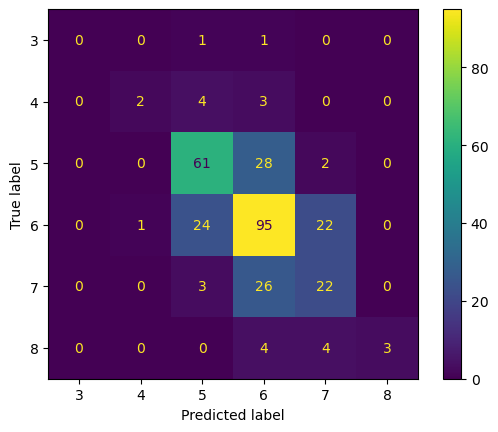

Roc_Auc_Score for wine quality 3 is: 0.852796052631579
Roc_Auc_Score for wine quality 4 is: 0.8034044145155257
Roc_Auc_Score for wine quality 5 is: 0.8558650651673908
Roc_Auc_Score for wine quality 6 is: 0.6860185503263483
Roc_Auc_Score for wine quality 7 is: 0.8212995001922337
Roc_Auc_Score for wine quality 8 is: 0.8453004622496147


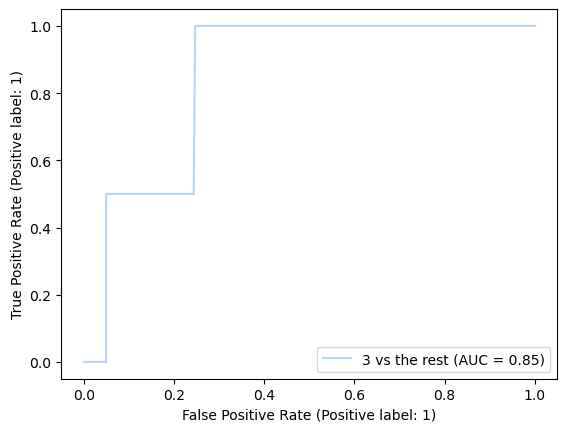

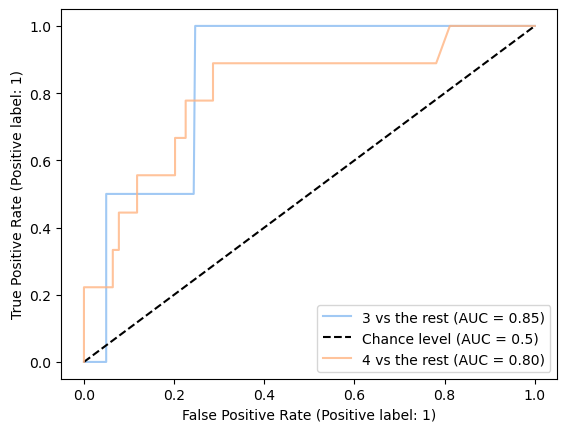

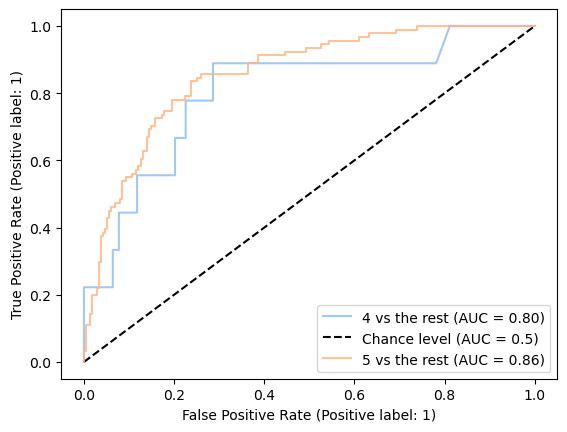

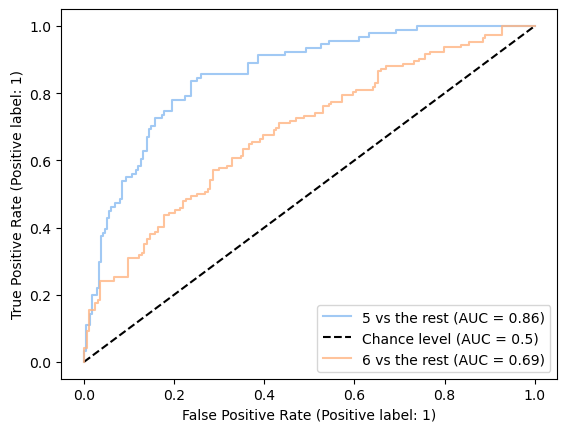

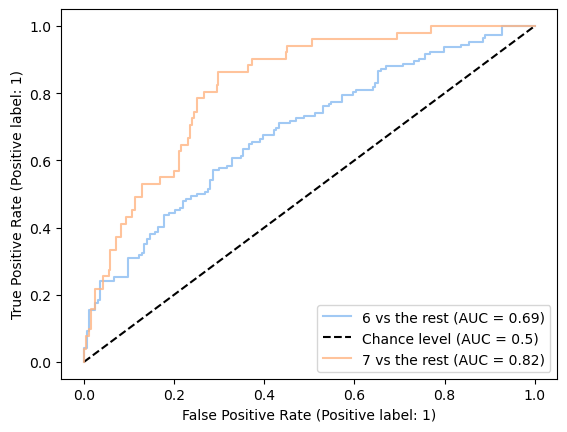

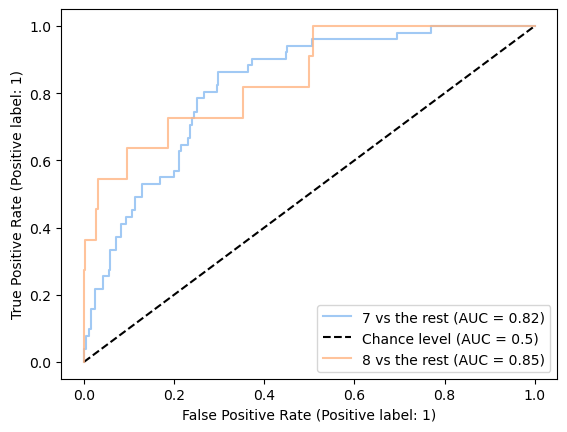

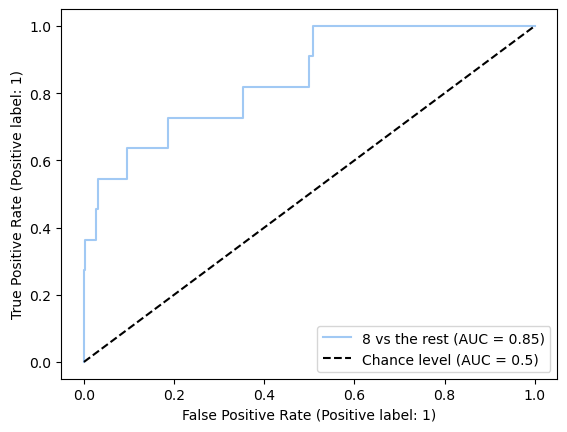

In [20]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
bayes_searcher = BayesSearchCV(rfc, rfcparams, n_jobs=-1, cv=cv)

for b in range(10):  
    #Incorporate meta-learning on smaller subsets'
    sample_wine = pd.read_csv("winequality-white.csv",sep=';').sample(frac=0.25)
    sample_labels = sample_wine.pop('quality')

    X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(sample_wine, sample_labels, random_state=0)
    report_perf(bayes_searcher, X_train_25, y_train_25, X_test_25, y_test_25 , "BayesSearchCV", "Meta 25%")

Train Accuracy: 1.0
Test Accuracy: 0.5032679738562091
BayesSearchCV best score post refit: 0.48908291755761457
best params: OrderedDict([('algorithm', 'kd_tree'), ('leaf_size', 50), ('n_jobs', -1), ('n_neighbors', 50), ('weights', 'distance')])
Total Mean Time for ML (in seconds):  6.385818004608154


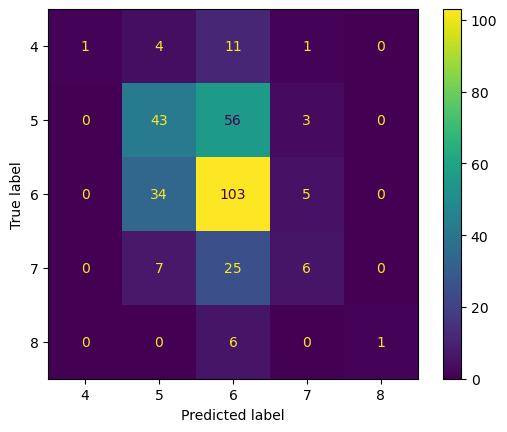

Oh well, I cant do this for whatever reason
Roc_Auc_Score for wine quality 4 is: 0.8489721147974761
Roc_Auc_Score for wine quality 5 is: 0.7115051903114187
Roc_Auc_Score for wine quality 6 is: 0.6517090346959807
Roc_Auc_Score for wine quality 7 is: 0.7322270227808327
Roc_Auc_Score for wine quality 8 is: 0.7004300047778308
Train Accuracy: 1.0
Test Accuracy: 0.4803921568627451
BayesSearchCV best score post refit: 0.48911261582323595
best params: OrderedDict([('algorithm', 'auto'), ('leaf_size', 20), ('n_jobs', -1), ('n_neighbors', 50), ('weights', 'distance')])
Total Mean Time for ML (in seconds):  6.815119028091429


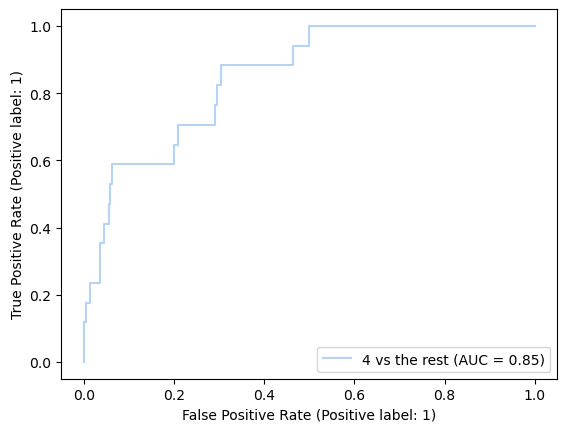

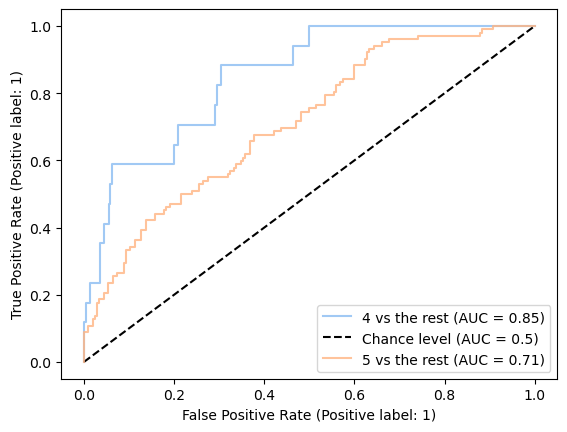

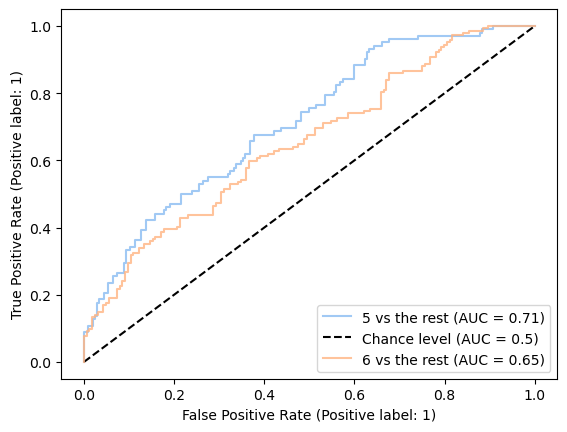

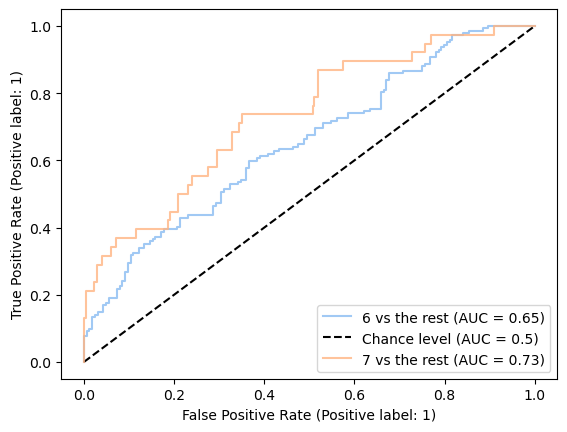

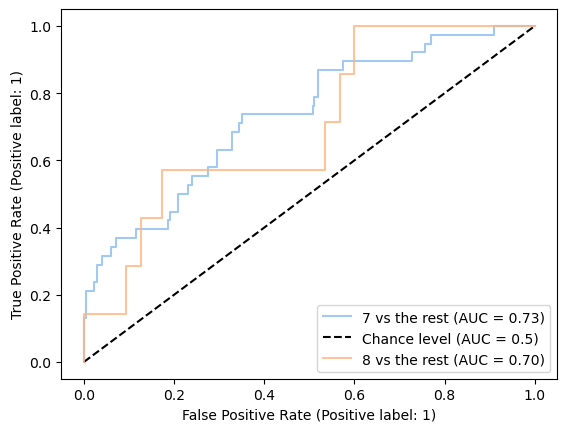

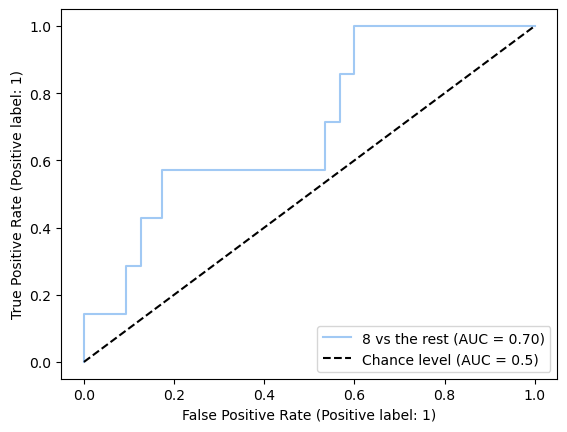

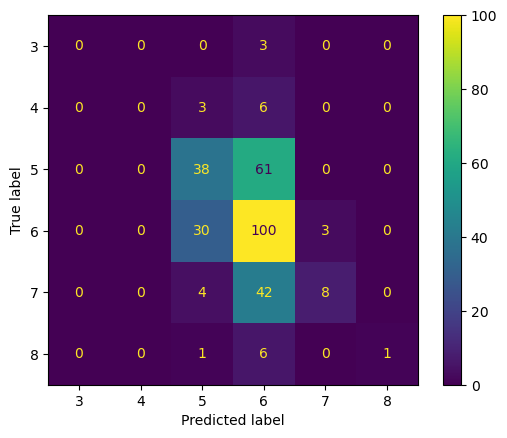

Roc_Auc_Score for wine quality 3 is: 0.8036303630363035
Roc_Auc_Score for wine quality 4 is: 0.5476992143658811
Roc_Auc_Score for wine quality 5 is: 0.7457668472161226
Roc_Auc_Score for wine quality 6 is: 0.5954626450519361
Roc_Auc_Score for wine quality 7 is: 0.7573486184597296
Roc_Auc_Score for wine quality 8 is: 0.6751258389261745
Train Accuracy: 1.0
Test Accuracy: 0.46405228758169936
BayesSearchCV best score post refit: 0.5011582323592302
best params: OrderedDict([('algorithm', 'auto'), ('leaf_size', 10), ('n_jobs', -1), ('n_neighbors', 50), ('weights', 'distance')])
Total Mean Time for ML (in seconds):  7.036345720291139


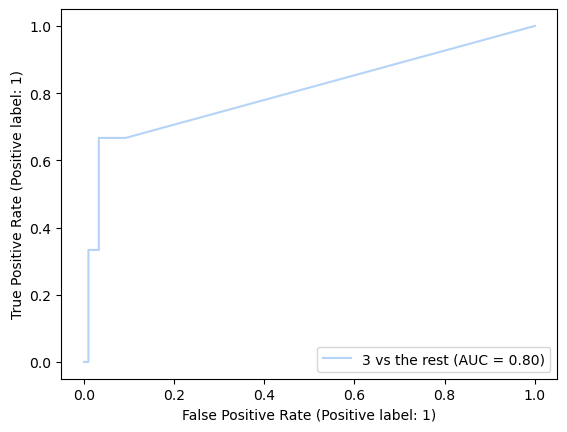

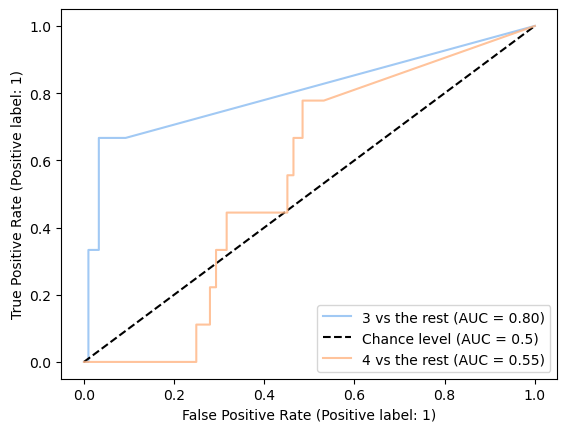

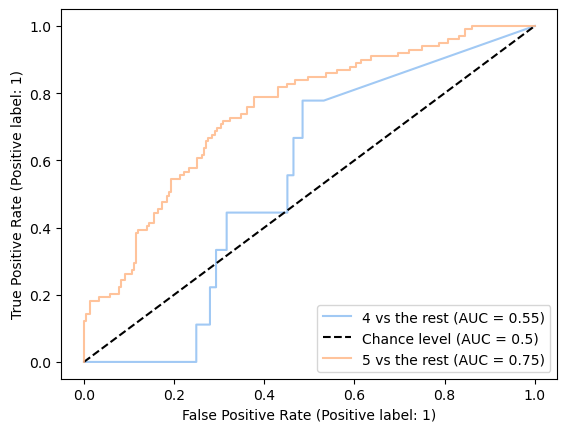

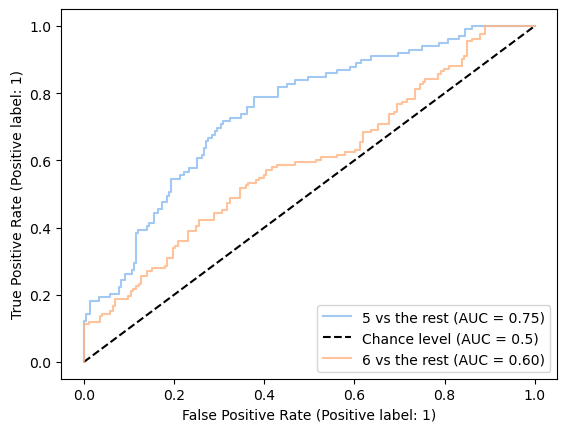

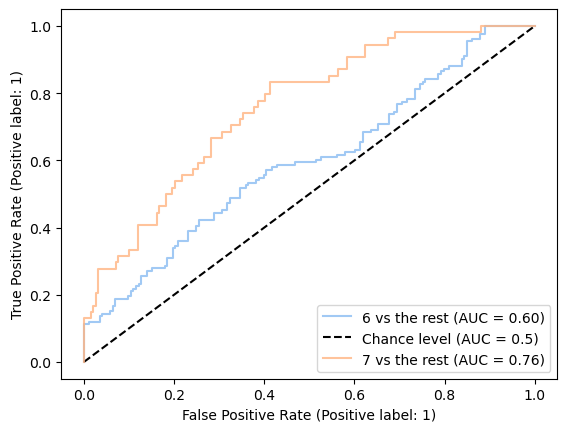

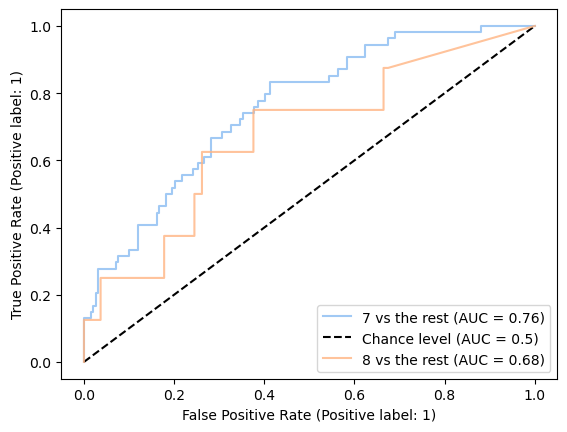

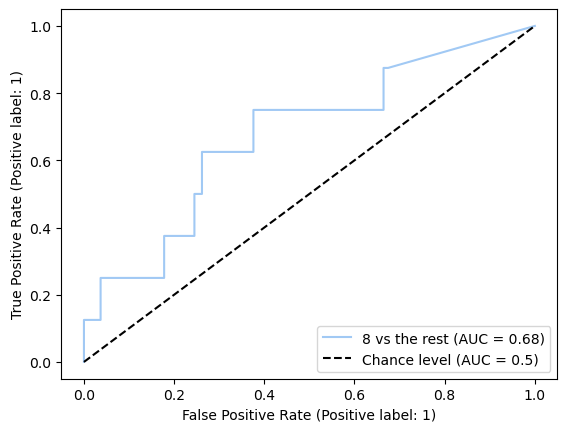

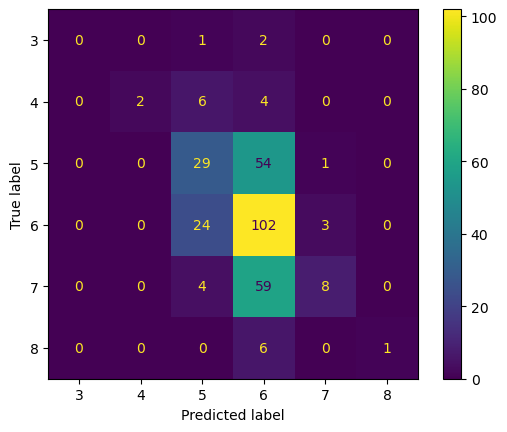

IndexError: index 0 is out of bounds for axis 0 with size 0

In [21]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
bayes_searcher = BayesSearchCV(knn, knnparams, n_jobs=-1, cv=cv)

for b in range(10):  
    #Incorporate meta-learning on smaller subsets'
    sample_wine = pd.read_csv("winequality-white.csv",sep=';').sample(frac=0.25)
    sample_labels = sample_wine.pop('quality')

    X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(sample_wine, sample_labels, random_state=0)
    report_perf(bayes_searcher, X_train_25, y_train_25, X_test_25, y_test_25 , "BayesSearchCV", "Meta 25%")

In [ ]:
#Base Bayesian Search Optimizer from skopt:  

report_perf(bayes_searcher, X_train, y_train, X_test, y_test, "BayesSearchCV", "Full Train Set")

In [ ]:
display(performance_scores)

performance_scores.to_excel('performance_scores.xlsx', index=False)

In [ ]:
#Re-get clean data

transwinedat = pd.read_csv("winequality-white.csv",sep=';')
winelabels = transwinedat.pop('quality')

scaledata = pd.DataFrame(StandardScaler().fit_transform(transwinedat), columns=transwinedat.columns)

logscaledat =logtrans(transwinedat)
logscalefinaldf = pd.DataFrame(StandardScaler().fit_transform(logscaledata), columns=logscaledata.columns)


final_rfc = RandomForestClassifier(**bayes_searcher.best_params_)
final_scores=[]

kFold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index,test_index in kFold.split(logscalefinaldf, winelabels):
    X_train, X_test = logscalefinaldf.iloc[train_index], logscalefinaldf.iloc[test_index]
    y_train, y_test = winelabels.iloc[train_index], winelabels.iloc[test_index]

    final_rfc = RandomForestClassifier(**bayes_searcher.best_params_)
    final_rfc.fit(X_train, y_train)
    finaltrainpred = final_rfc.predict(X_train)
    finaltestpred = final_rfc.predict(X_test)

    final_scores.append([accuracy_score(finaltrainpred, y_train),
                   accuracy_score(finaltestpred, y_test)])

    winematrix = confusion_matrix(y_test, finaltestpred)
    mylabels = np.unique(np.concatenate((y_test,finaltestpred),0))
    disp = showMatrix(winematrix, display_labels=mylabels)
    disp.plot()
    plt.grid(False)
    plt.show()
    y_score = final_rfc.predict_proba(X_test)
    
    label_binarizer = LabelBinarizer().fit(y_train)

    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (num_samples, num_classes)
    
    for class_of_interest in range(3, max(y_test)+1):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        ax = plt.gca()
        try:
            roc = roc_auc_score(y_onehot_test[:, class_id], y_score[:, class_id], 
                                labels=labels, multi_class='ovr')
            print("Roc_Auc_Score for wine quality", class_of_interest, "is:", roc)

            rfc_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id], y_score[:, class_id],
                                                        name=f"{class_of_interest} vs the rest",
                                                        plot_chance_level=True) 
            rfc_disp.plot(ax=ax, alpha=0.8)
        except:
            print('Oh well, I cant do this for whatever reason')

display(final_scores)
